First principles of "doing stuff" are things like graph and numeric operations, and search and optimizers.

So let's… do those.

We'll use Python, of course, the slowest gun in the West.    
This is in a Jupyter notebook.    
It's funny and educational.    
Maybe leave.    
Maybe read through.    
Maybe clone and play with code.    
Maybe clone and erase and implement some code for full mastery.    
Have fun doing what you want to do.

```bash
sudo apt install python3 python3-pip
pip3 install jupyter
```

## Examples

First, the interfaces that we'd like to use, for inspiration.    
No need to understand them all completely for now. Understanding goes with implementation, which is below all these.

(Cannot run them, only look.)

Search for hyperparameters:

```python
@state(a=real(0,1), b=one('x', 'y', 'z'), c=one('x', 'y', 'z'))
@examples((0.2, 'x'), (0.8, 'z'))
def probability_to_char(st, x):
    return st.b if x < st.a else st.c

print(probability_to_char(0.9)) # 'z'
```

Search for a linear decision tree:

```python
@state(
    result = label('num'),
    num = one(
        0,
        1,
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x+y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x-y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x*y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x/y),
        compose(label('num'), label('num'), label('num'), label('num'), out=label('num')(lambda x,a,b,c: b if x<a else c)),
    )
)
def hidden_learned_numeric_function(st, x: label('num'), y: label('num')):
    return st.result
# Can also be written as:
# hidden_learned_numeric_function = state( result=… )('result')


@examples((1, 10), (2, 15), (3, 16), (4, 5234), (10, 10000))
def learned_function(x):
    return hidden_learned_numeric_function(x, x*x) + 10

log(learned_function(7))

log(state._get_impl(learned_function))
```

```python
# Pattern-matching on an input.
import math
@state(
    result = label('num'),
    num = one(
        0,
        1,
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x+y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x*y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: x/y),
        compose(label('num'), label('num'), out=label('num'))(lambda x,y: math.pow(x,y)),
    )
)
def hidden_learned_numeric_function2(st, f: one('x', 'y', one.object_id), x: label('num')):
    return st.result


@examples((1, 2), (2, 4), (3, 8))
def learned_function1(x):
    return hidden_learned_numeric_function2('x', x)

@examples((1, 2), (2, 4), (3, 6))
def learned_function2(x):
    return hidden_learned_numeric_function2('y', x)

@examples((1, 10), (2, 11), (3, 12))
def learned_function3(x):
    return hidden_learned_numeric_function2(learned_function3, x)

print(learned_function1(4), learned_function2(4), learned_function3(4))
```

Persistence:

```python
@state(
    'learned123213',
    a = real(0,1)
)
def met(st):
    return st.a
for i in range(100):
    examples.add(met, out = 0.5 + i/200)

state.load('saveToAndLoadFrom.bin', autosave = False)
examples.fit(examples.new, examples.timeout(5))
examples.fit(examples.all, examples.timeout(.5))
state.save()
```

State inlining (multiple callsites of the same function in another function get treated as one) (analogous to transfer learning):

```python
@state(a=one(1,2))
@examples(1)
def function1(st):
    return st.a

@state(a=2)
@examples(4)
def function4(st):
    return function1() + st.a

print(function1(), function4()) # 1, 4

log(state._get_impl(function1).a) # history(one(1,2), 1)

# Accomplished via automatically randomly calling:
# state.inline(function4, function1)
```

Max/min-imization:

```python
@state(a = real(-1,1), b = real(-1,1), c = real(-1,1))
@examples(*( (x*10, float('-inf')) for x in range(-10, 10) ))
def minimize_at_points(st, x):
    a = st.a * st.a
    b = (st.b + 0.1) * (st.b - 0.5)
    c = abs(st.c * x)
    return a + b + c + x

import matplotlib.pyplot as plt
plt.plot([minimize_at_points(x) for x in range(-100, 100)])
plt.ylabel('minimize_at_points')
plt.show()
```

Internals: `compose.context`/`.in`/`.out` (used for search) and arbitrary types.

```python
# There is no one best search method and details,
#   so these 'internals' make search simple enough to hopefully be customized easily.
with compose.context(num = 1):
    with compose.context(num = 2):
        with compose.context(num = 3):
            print(compose.out(label('num'))) # one(1, 2, 3)

with compose.context(1, 3, 5, 7, 9, num = real(0,10)):
    x = one(1, 2, label('num'))
    print(compose.ins(x)) # one._pattern_match(1, 2, 'num')
    print(compose.out(x)) # (1, 2, real(0, 10))
    y = compose.type((1, 2, 3), None) # (enum)
    print(compose.ins(y)) # (1, 2, 3)
    print(compose.out(y)) # None — no further composition needed, usable as-is if found.
    z = compose.type(None, lambda x: x if isinstance(x, int) and x <= 5 else None) # (filter)
    print(compose.ins(z)) # None
    print(compose.out(z)) # (1, 3, 5)
    w = compose.type(None, lambda x: x)
    print(compose.ins(w)) # None
    print(compose.out(w)) # (1, 3, 5, 7, 9, real(0, 10))



# Internals: picking from options.
import random
def random_index(*a):
    L = len(a)
    return random.int(0, L-1) if L > 0 else None
with compose.picker(lambda a: random_index(x for x in a if x>=5)):
    with Context(1, 5, 10):
        top = compose.type(None, lambda x: x)
        print(Context.get(top)) # 5 or 10
        print(*(x for x in Context.enum(top))) # 5,10 or 10,5



# Internals: undo-enabled transformations.
#   (Spoiler from the future: didn't pan out, got removed.)
undo_example_default_a = history(real(0,10), one(1,2,3), 2)
undo_example = state(
    a = undo_example_default_a
)('a')

state._set_body(undo_example, 'a', undo_example_default_a)

# The appropriate value will be found much faster than with just a=real(0,10).
examples.add(undo_example, out = 3)
examples.fit(undo_example, examples.timeout(.1))
print(undo_example()) # 3
# In operations that our library implements, for each type of set,
#   we'd like to have set=>subset functions that rely on history to speed up minor changes.
```

Search optimization (optimize how fast things are optimized):

```python
for i in range(10):
    start_time = examples.time()
    def search_speed(f, got, expected):
        return examples._loss(f) / start_time()
    with compose.context(metrics = search_speed):
        examples.fit(examples.all, examples.timeout(1))



# Memory limiting and optimization.
@state(
    result = one('x', compose(lambda x: x+1, 'x', 'x'))
)
def mem_limiting_example(st, x: 'x'):
    return st.result
state.byte_limit(mem_limiting_example, 100) # Limit the sum of sys.getsizeof()


def memory(since = 0):
    # Somewhat accurate to kilobytes.
    import resource
    u = resource.getrusage(resource.RUSAGE_SELF)
    mem = u.ru_ixrss + u.ru_idrss + u.ru_isrss
    if not mem:
        mem = u.ru_maxrss
    if sys.platform != 'darwin':
        mem = mem * 1024
    return mem - since
start_memory = memory()
with compose.context(metrics = lambda f,g,e: -memory(start_memory)):
    examples.fit(examples.all, examples.timeout(5))

# These are areas where it is practically impossible to come up with universally good metrics or optimization way,
#   so advanced metric (and search-impl) enumeration and search would be required.
```

## Why

Ah, the age-old question of "why does this exist?".

To put it simply, right now we want to make a reliable library for adding structural learning to ML's numerical learning, similar to AutoML frameworks. But our thinking that led to this is broader.

Intelligence is beyond static descriptions and beyond static numerics.    
Natural language transformer networks, using comments to select which feature is the most appropriate to implement another.    
A mental list of tasks that a person does, having spent a lifetime learning when to take on a new task, when to work on the list, when the work is good enough, and when to give up.    
Vast groups that co-learned the same meanings and implications of words, and the gradual drift of those meanings and eventually words themselves over time, in groups and individuals alike.    
People learning how to adjust the program they wrote in response to errors they see, learning appropriate dynamic contexts of static parameters (if they depend on the phase of the moon, it will be found out), and learning re-usable parts and when to learn them for most effective transfer learning.    
Only a fully dynamic thing behaves like that.

Here, we hope to try out a new stateful approach to writing software, where only the most important things are formalized, and the rest is learned.

We'd like to put lessons of machine learning (mainly "don't write down one way, write down all ways, and defer choices to the machine") into a non-numeric form.

More, we'd like an arbitrary-program optimization base that can represent and optimize fully-dynamic behavior. For science.

Let's not dwell on this, because asking why is how things die.

## Carcass

Our next step here is to consolidate all those examples into the library's skeleton, which includes full interfaces and comments on how each function is to be implemented. This is very preliminary, as all implementation-less interfaces are.

In [1]:
# Public interface:

# state(__name = None, **vars)(func_or_varname)
#   load(filename, autosave = True)
#   save(filename = last_loaded_filename)
#   override(func_id_to_impl) -> context_manager
#   pprint(state)
#   inline(func = None, inner_func = None, inline = 1)
#   byte_limit(func, bytes)
#   _get_impl(func, varname = None)
#   _set_impl(func, varname, impl)
# examples(*args_to_out)(func)
#   add(func, *args, out)
#   fit(func, stopping_check)
#   timeout(ms) -> function finished()->bool
#   time() -> function time_since()->ms
#   new: list
#   all: list
#   _loss(func)
# compose(func, *arg_sets, out)
#   context(*values, **label_set_additions) -> context manager
#   ins(object)
#   out(object)
#   type(enum, filter)
#   picker(list_to_index_function) -> context manager
#   pick(object)
#   picks(object) -> iterator
# match(value, branches)
#   id
# label(name)
# history(*past_then_present) datatype
# many(*of) datatype
# one(*of) datatype
# real(min, max) datatype
# int(min, max) datatype

# Executing a function, with composable arbitrary backprop:
#   execute(func, ins = None) -> many(out, exec_state)
#   adjust(func, ins, out, dout, exec_state) -> dins

# _parse(bytes) -> obj
# _serialize(obj) -> bytes

import sys # getsizeof
import math # isinf
import time # clock
import random
import inspect # getsource
import weakref # finalize, WeakValueDictionary
from numbers import Number

# All datatypes have a uniform repr:
#   Struct(head, *data) which inherits from list.
_bytes = 0
class Struct(list):
    def __init__(self, *head_then_args):
        global _bytes
        super().__init__(head_then_args)
        _bytes += sys.getsizeof(self)
        # Keep track of byte-precise memory ourselves.
    def __del__(self):
        global _bytes
        _bytes -= sys.getsizeof(self)
        # Assuming that structs are immutable.




class State:
    # Using @staticmethod is too verbose.
    # Is there any other way to do non-file-based namespacing in Python?

    def __call__(_, __name = None, **kwvars):
        """Decorator for specifying state state for functions.
        A function will have an extra arg in front for getting state; do not store it."""
        ## is TBD
        def decorate(func):
            nonlocal __name
            if __name is None:
                __name = inspect.getsource(func)
            ## And set _state_names[__name] to func for save/load.
            func.states = {id(func):kwvars}
            def replacement(*args, **kwargs):
                global _current_func
                _current_func = func
                with state.override(func.states):
                    return func(_current_state_object, *args, **kwargs)
            for k,v in vars(func).items():
                setattr(replacement, k, v)
            return replacement
        return decorate
    
    def load(_, filename, autosave = True):
        """Loads global state from file."""
        ## Read file bytes.
        ## Turn file bytes into an object graph with _parse(bytes).
        ## Set functions' states named in _state_names to what they are in the graph.
        pass
    
    def save(_, filename = None):
        """Saves global state to file, the last loaded one by default."""
        ## that = {k:state._get_impl(v) for k,v in _state_names.items()}
        ## Get bytes with _serialize(that).
        ## Write them.
        pass
    
    def override(_, func_id_to_state):
        """Returns a context manager that overrides function impls, for inlining."""
        class StateSetter:
            __slots__ = ['fs']
            def __init__(self, fs):
                self.fs = fs
            def __enter__(self):
                for func_id, state in self.fs.items():
                    _states[func_id] = state
            def __exit__(self,x,y,z):
                for func_id, state in self.fs.items():
                    del _states[func_id]
        return StateSetter(func_id_to_state)
    
    ## Do we need `func` in these three; isn't it always the current func?
    def _run_impl(_, func, varname):
        """Get and execute an impl."""
        impl = state._get_impl(func, varname)
        out, exec_state = execute(impl)
        ## And store exec_state in func's current exec_state cell.
        return out
    
    def _get_impl(_, func, varname = None):
        """Get a function's impl in the current state."""
        # Lookup in the first override of func in _states.
        if id(func) in _states:
            state = _states[id(func)]
            if varname is None:
                return state
            elif varname in state:
                return state[varname]
        return None
    
    def _set_impl(_, func, varname, impl):
        """Set a function's impl in the current state."""
        if id(func) in _states:
            state = _states[id(func)]
            state[varname] = impl
    
    def pprint(_, obj):
        """Pretty-prints an object."""
        pass
    
    def inline(_, func = None, inner_func = None, inline = 1):
        """Sets the global state inlining policy."""
        pass
    
    def byte_limit(_, func, bytes):
        """Sets the maximum byte count that a function's state can take."""
        pass

state = State()



class _CurrentState:
    def __getattr__(self, attr):
        return state._run_impl(_current_func, attr)

_current_state_object = _CurrentState()

_states = {}
_current_func = None



class Examples:
    def __call__(self, *args_to_out):
        """A decorator for associating input-output examples with a function."""
        def decorate(func):
            func.examples = args_to_out
            examples.all.append(func)
            weakref.finalize(func, examples.all.remove, func)
            return func
        return decorate
    
    def _loss(_, func, exs = None):
        """Computes the loss of a function over all its examples, to be minimized."""
        if exs is None:
            exs = func.examples
        dsum = 0
        for ex in exs:
            # This slice might allocate, meaning that it should be pre-done in `examples`.
            # I don't know enough about Python internals.
            intended_ins, intended_out = ex[0:-1], ex[-1]
            out, exec_state = execute(func, intended_ins)
            if not isinstance(intended_out, Number):
                dout = 0 if intended_out == out else 1
            elif not math.isinf(intended_out):
                dout = abs(out - intended_out)
            elif intended_out > 0: # +∞
                dout = -out
            else: # -∞
                dout = out
            dsum += dout
            ## We have exec_state here,
            ##   we could use it by passing it to `adjust`,
            ##   or by returning a random one.
            ## But "when" is unclear.
            ##   We'd like to optimize that automatically, later.
        return dsum
    
    def add(_, func, *args, out):
        """Adds an example to a function's example list."""
        func.examples.append((*args, out))
    
    def fit(_, func = None, stopping_check = None):
        """Executes and adjusts a function on any of its examples.
        Returns when stopping_check returns True."""
        if stopping_check is None:
            stopping_check = examples.timeout(.5)
        ## while not stopping_check():
        ##   pick random example
        ##   execute
        ##   adjust
        # (Or add up loss and sample state of several examples and adjust.)
        pass
    
    def timeout(s):
        """Returns a function that returns True when the given seconds have passed."""
        end_s = time.process_time() + s
        def finished():
            return time.process_time() <= end_s 
        return finished
    
    def time():
        """Returns a function that returns seconds passed since its creation."""
        start = time.process_time()
        def time_since():
            return time.process_time() - start
        return time_since
    
    new = []
    all = []

examples = Examples()



class Compose:
    def __call__(_, *arg_sets, out):
        """"""
    
    def context(_, *values, **label_set_additions): # -> context manager
        """"""
    
    def ins(_, obj):
        """"""
    
    def out(_, obj):
        """"""
    
    def type(_, enum, filter):
        """"""
    
    def picker(_, list_to_index_function): # -> context manager
        """"""
    
    def pick(_, obj):
        """"""
    
    def picks(_, obj): # -> iterator
        """"""

compose = Compose()



class Label:
    __slots__ = ('name', '__weakref__')
    def __init__(self, name):
        self.name = name
    def __hash__(self):
        return hash(self.name)
    def __eq__(self, other):
        if isinstance(other, Label):
            return self.name == other.name
        return False
    # Python 3 needs no __ne__

_label_cache = weakref.WeakValueDictionary({})

def label(name):
    """Returns an object that is guaranteed to be the same for equal values of `name`."""
    if name not in _label_cache:
        L = Label(name) # Why is putting it on the same line make it call the getter?
        _label_cache[name] = L
    return _label_cache[name]



class Match:
    def __call__(self, value, branches):
        """"""
        pass
    id = """Pattern-matches on id(object)."""

match = Match()



class History:
    """A transformed value, able to be returned to its past state."""
    def __call__(self, *past_then_present):
        return Struct(History, *past_then_present)

history = History()



class Many:
    """Basically an array.
    Multiple values at once, able to be decomposed into each with `access_many`.
    When a value of a `many(…)` set is an input, becomes decomposed into each part.
    When an output, generates each branch, then puts results into an array."""
    def __call__(self, *of):
        return Struct(Many, *of)

many = Many()

def access_many(m, index):
    return m[index]



class One:
    """Basically a choice.
    Any value from ones listed, able to be recognized with `match`.
    When a value of a `one(…)` set is an input, becomes pattern-matched.
    When an output, selects a random branch to go to (with a pattern-match)."""
    def __call__(self, *of):
        return Struct(One, *of)

one = One()



class Real:
    """Any scalar number from min to max."""
    def __call__(self, min, max):
        return Struct(Real, min, max)

real = Real()



class Int:
    """Any integer from min to max."""
    def __call__(self, min, max):
        return Struct(Int, min, max)

# int = Int()



def execute(func, ins = None): # -> many(out, exec_state)
    while True:
        if isinstance(func, Struct):
            if func[0] is Real:
                func = random.uniform(func[1], func[2])
            elif func[0] is Int:
                func = random.randint(func[1], func[2])
            ## Also handle Many via actual recursion.
            elif func[0] is One:
                i = random.randint(1, len(func)-1)
                func = func[i]
            elif func[0] is History:
                func = func[-1]
        ## Also execute if an SSA.
        elif isinstance(func, Label):
            func = state._get_impl(_current_func, func.name)
        elif callable(func) and ins is not None:
            return func(*ins), None
        else:
            return func, None
def adjust(func, ins, out, dout, exec_state): # -> dins
    pass



def _parse(b):
    pass
def _serialize(obj):
    pass

Midway through, I turned my brain off and went coding and learning Python along the way, so this carcass crawls with maggots: setting and getting static state works, setting examples works (but not fitting to them), flyweight labels work. Did not touch composition nor parsing+serialization, nor specialization nor execution.

I have struggled with the Python language in a few places.    
Following a reference to its definition is burdensome enough that I need to try and mentally track as much scope as I can.    
I can't be completely sure that other code won't read the properties I'm defining.    
I'm not sure about performance of particular things.    
Namespacing is weird and causes semantic noise.    
But that doesn't mean that some super language should be made that will have no mistakes in its design, even if that possibility seems closer every year.    
Certainly, efforts toward that can be made, and each will improve the situation. That's the danger of static-goal universal optimizers: optimizers that outperform them probably exist.    
Planning is everything and plans are nothing, a world model beats expert knowledge, a language is irrelevant next to the ability to make one, and dynamic is always better than static.    
That's why I'm exploring this library of dynamic generation.

Let's excise bugs by looking at how the implemented functionality behaves:

In [2]:
@state(a=real(0,1), b=one('x', 'y', 'z'), c=one('x', 'y', 'z'))
@examples((0.2, 'x'), (0.8, 'z'))
def probability_to_char(st, x):
    return st.b if x < st.a else st.c

for _ in range(3):
    print(probability_to_char(0.2), probability_to_char(0.8))
    print(probability_to_char(0.2), probability_to_char(0.2), probability_to_char(0.2))
    print(examples._loss(probability_to_char))

y y
z z y
1
x y
y x z
1
y x
x z z
2


Loss should be `0`/`1`/`2` (count of failed examples), and everything should vary constantly, because we don't sometimes rewrite state by specializing, and pick everything dynamically.

Rewriting rules and specializing with history (and `examples.fit`) should be next, to make the first example actually work.

## History

I've been thinking about program search and realized something.

Random search or evolution are: pick a random part to put into result, or pick a random part to alter/crossover randomly.

(Neural networks could be used to estimate/learn how good a choice and a resulting graph are [[Y]](https://arxiv.org/pdf/1910.11858), but structures of search and NNs are still static, and NNs' messy vocabulary makes "learning" mean only its particular kind of change. I want another change, the real search of structure.)

But that arbitrary choice can be much more than picking a random number each time and being satisfied.

We can remember the choice and maybe change it later, or replace it with a choice from a subset, or decide what to do with an arbitrary computation, generated with all this too; then maybe remember our work somewhere, decide when to forget.

This needs state, but if we have state, we can learn it.

And so, to try to reach and push the state-of-the-art on search, the idea of this library was born.

---

Previously, I spent half a year making a programming language that is perfect, has many powerful features, and is so uniform it can be written automatically.

But I realized: every new feature is another feature away from what allows intelligent behavior.

For that, a primitive SSA is better than very convenient semantics, and a library serves better than a full language.

A mind is not given to you, and must be learned from the start: 'nothing' is indistinguishable from 'everything', but 'something' is neither.

I know a lot of people blame how primitive code entry tools are, but from what I've seen, the only and real problem is the lack of intelligence in machines: 50% more thoughts captured will never equal a mind. Until the singularity is trusted and widespread, every tool will seem stone-age.

To help that, we must learn to change without fear.    
Find the everythings that can give rise to all the somethings, implement them, and make a system to learn something simple.

## Specializing with history

For real this time.

We want to be able to specify a function, that will turn an executable value in a state (`impl`) into its special case; we'd then put `history(Old, New)` back.

We can't just say "hey, user, just write whatever you want in this spot", we have to handle all cases that we've made and connections between them.    
In other words, we need to explicitly do a DAG rewrite (directed acyclic graph — basically, where objects are created one-by-one, with immutable-at-creation-time connections).    
Say, `rewritten(impl, func)` is the graph rewrite.

What does rewriting a thing with connections mean?    
Node type (whether it's a `One` or `Real` or others) is important.    
Rewrite connections (without repeating work), then rewrite the thing. There might not be connections, which we'll have to check for.    
Maybe we don't rewrite a particular node, but still want to build up some estimate for decision-making, so we need an input and an output for that.    
Which means that inputs of a rewriting function are (informally) `(estimate | None, node)`, where it's a good idea to match the first item in `node` by object id; and outputs are `many(estimate, node_becomes | None)`.    
`node_becomes` here is made by decomposing `node`, and later we'll have to specify a complete basic set of rewrites. That decomposition won't have access to new nodes, so we'll have to update `node_becomes` manually in `rewritten`.

Where would we use this function? We could try doing it with a 10% chance in `execute`, or make `adjust` walk the DAG and rewrite an impl with a 1% chance.    
Inability to find a good place for structural change may be discouraging, but that's what "we'll come back to dynamically optimize the search itself later" is for.

Enough talk, let's program it.

In [3]:
def rewritten(impl, func):
    # Walk the graph, apply `func(recursive_estimate, *node)` to each node.
    def walk(node, func, env):
        """Fills a dictionary with graph nodes' rewriting results and recursive estimates.
        `node` is a list with the node type being the first item and graph edges following, or anything else.
        `func` is like `compose('estimate', node, out=many('estimate', 'node_becomes'))`, decomposing nodes up to depth of 1.
        `env` is a dict from id(node) to the node's recursive estimate and node_becomes."""

        # The graph-walk header:
        if id(node) in env:
            return env[id(node)][0]
        env[id(node)] = None # Unneeded if there are no cycles, but good to remember.

        # Get and sum estimates of children, then pass that to `estimate`.
        ## (Any other order-independent number op can be used: mult, mean, min/max.)
        # Every one of our datatypes is a Struct, so getting connections is very simple.
        s = None
        is_struct = isinstance(node, Struct) and len(node) >= 1
        post = Struct(*node) if is_struct else node
        any_change = False
        if is_struct:
            for i in range(1, len(node)):
                child_est = walk(node[i], func, env)
                post[i] = env[id(node[i])][1]
                if post[i] is not node[i]: any_change = True
                if child_est is not None:
                    s = child_est if s is None else s + child_est

        # Collect post-rewrite dependencies in `post`.
        s, becomes = func(s, post)

        # Remember the rewrite.
        if becomes is None:
            becomes = post if any_change else node
        env[id(node)] = (s, becomes)
        return s
    env = {}
    walk(impl, func, env)
    return env[id(impl)][1]

This isn't a complete implementation of rewriting, there should also be its adjusting part to balance out the execution part we've just made: remember `env`, then post-order traversal of execution becomes pre-order traversal of adjustment.

With this, what `adjust` should be and do becomes more clear: the `@attr(adjust = adjust_override)` decorator for easily specifying its overrides, and `adjust` itself should propagate in a breadth-first manner, and handle visiting-same-node-many-times (where adjustments should be summed).

We won't do that for now, because we have a bigger problem: lacking a representation for computations. This problem may or may not make us rewrite rewriting.

Example usage of `rewritten`, to excise bugs:

In [4]:
def real_rewrites(_, a, b):
    from numbers import Number
    if isinstance(a, Number) and isinstance(b, Number):
        if a + 4 < b:
            return real(a+2, b-2)
        if a + 2 < b:
            return real(a+1, b-1)
    return a if random.randint(0,1) == 0 else b

def r(_, node):
    if isinstance(node, Struct) and node[0] is Real:
        if random.randint(0,1) == 0: # 50%
            return 0, real_rewrites(*node)
    return 0, None

[rewritten(one(real(1,3), real(real(0,1),4), real(1,5), real(1,6), 15), r) for _ in range(5)]

[[__main__.One,
  1,
  [__main__.Real, 0, 1],
  [__main__.Real, 2, 4],
  [__main__.Real, 3, 4],
  15],
 [__main__.One,
  [__main__.Real, 1, 3],
  4,
  [__main__.Real, 2, 4],
  [__main__.Real, 1, 6],
  15],
 [__main__.One,
  [__main__.Real, 1, 3],
  [__main__.Real, 0, 1],
  [__main__.Real, 2, 4],
  [__main__.Real, 3, 4],
  15],
 [__main__.One,
  3,
  [__main__.Real, [__main__.Real, 0, 1], 4],
  [__main__.Real, 2, 4],
  [__main__.Real, 3, 4],
  15],
 [__main__.One,
  3,
  [__main__.Real, 1, 3],
  [__main__.Real, 2, 4],
  [__main__.Real, 1, 6],
  15]]

Okay, for *real* real this time, specialization with history, also known as fearless rewriting:

In [5]:
from numbers import Number

def real_specialize(_, a, b):
    if isinstance(a, Number) and isinstance(b, Number):
        return random.uniform(a, b)

def one_specialize(_, *opt):
    return random.choice(opt)

def history_generalize(_, past, present):
    return past

def specialize_y(_, node):
    becomes = None
    if isinstance(node, Struct) and random.randint(0,1) == 0: # 50%
        if node[0] is Real:
            becomes = real_specialize(*node)
        if node[0] is One:
            becomes = one_specialize(*node)
        if node[0] is History and len(node) == 3:
            becomes = history_generalize(*node)
    if becomes is not None:
        becomes = history(node, becomes)
    return 0, becomes

def to_initial(_, node):
    if isinstance(node, Struct) and node[0] is History:
        # Gotta get back, back to the past
        return 0, history_generalize(*node)
    return 0, None

def test():
    initial = one(real(1,3), real(real(0,1),4), real(1,5), real(1,6), 15)
    post1 = rewritten(initial, specialize_y)
    post2 = rewritten(post1, specialize_y)
    # The specialize-y function can be chained infinitely,
    #   and won't get stuck due to not perfectly-cyclic rewriting rules.
    back = rewritten(post2, to_initial)
    return ['1:', post1, '2:', post2, 'back:', back]
test()

['1:',
 [__main__.One,
  [__main__.Real, 1, 3],
  [__main__.Real,
   [__main__.History, [__main__.Real, 0, 1], 0.6812609421840116],
   4],
  [__main__.Real, 1, 5],
  [__main__.History, [__main__.Real, 1, 6], 4.705944477186281],
  15],
 '2:',
 [__main__.History,
  [__main__.One,
   [__main__.Real, 1, 3],
   [__main__.Real,
    [__main__.History,
     [__main__.History, [__main__.Real, 0, 1], 0.6812609421840116],
     [__main__.Real, 0, 1]],
    4],
   [__main__.History, [__main__.Real, 1, 5], 3.0381258043678714],
   [__main__.History,
    [__main__.History, [__main__.Real, 1, 6], 4.288923021480498],
    4.705944477186281],
   15],
  15],
 'back:',
 [__main__.One,
  [__main__.Real, 1, 3],
  [__main__.Real, [__main__.Real, 0, 1], 4],
  [__main__.Real, 1, 5],
  [__main__.Real, 1, 6],
  15]]

(In a real implementation, this should be done at execution or adjustment.)

I know what you're thinking.

"Why not just execute the whole impl, and add that with history? Could have been done in 1 line."

The answer is, because this approach won't teach anything.

We're exploring without a crystal-clear idea of what we want, so we need to make damn sure that we're teaching ourselves something that may be useful. This will pay dividends in the sequel.    
We wanted to handle structure properly, and structure *is* generally a graph, so we made (most of) a graph rewriting routine, so general that it can be used for a recursive neural network or any search through quantized rewrites.    
We found and made use of some principles: "always make space for a same-type input+output pair, for customizability/learnability by users", and "randomly apply any of these rules".    
And we simplified rewriting until it couldn't be simplified.

Maybe this code will be superseded, but its spirit will live on in other code.

## Composition

Before we can do anything at all interesting, we must be able to handle `compose`d computations properly.

There are two parts to that: execution and generation.

For generation, we'll need every way that output can possibly be computed from inputs.    
Pattern-matching on an arbitrary index to select the branch for the output.   
Pattern-matching on inputs.    
Decomposing inputs.    
Composing output.    
Looking at past values.    
Looking at future values, and adjusting once available.    
Matching input types to output types to compose functions.     
Creating many outputs, and predicting how well each of them will do.    
Numeric representations, and mixing every input into every output (neural nets).    
And don't forget about dynamic partial re-generation in rewriting.    
And don't forget loops and/or recursion.

but **other**

### Execution

It may come as a surprise to some, but outputs of functions can become inputs to others. It's true.

Which means that a function call should be represented with some object that stores the function to call and its inputs, which could be other such objects.    
We need some sort of graph structure, but with exactly zero ambiguity, ordering edges of each node.    
Like `Struct`.    
Yeah, that covers it entirely.    
In `execute`, if the `Struct` is a function, compute its inputs then call it.    
That big `if` nest can be replaced with one branch-to-data thing. (In fact, it had a big mistake: not recursing on inputs.)

If you're used to programming in programming languages, you're probably confused.    
Where are variable bindings?    
Where are instruction sequences?

Unneeded.

It's inconvenient to explicitly generate those, and rewriting becomes either really tricky or near-useless.    

But they do need some handling.

For variable analogues, we won't recompute nodes we've already computed in the current Python function call.    
We'll do this with a dict cache.    
(Note that if we had all nodes in a linear array, our internal representation would have been called SSA form — static single assignment: assigning each computed value to one variable. This would have replaced dict accesses with much more efficient list accesses. The best option, as always, is both: a DAG for rewriting, and its updated SSA form for execution. But it's complex, so we won't do that here.)    
Keeping all intermediate values does not reuse the CPU caches and so is inefficient, but we'll want to have `adjust` which will need all the values.

For sequence analogues, we'll need to ensure the lack of cycles, to know what is computed before what.    
I mean, what is a cycle in computation?    
A link to the past, to represent state? But which past, one execution ago or the execution where the phase of the moon was a werewolf?    
Or to the future, predicting a value that's not yet available? But predicting in what manner, and how is its accuracy ensured?    
No, a cycle is an error.    
And while making each constructed node immutable is enough to abolish cycles, rewriting can generally create them, so we'll need to remember that in generation of rewrites.

In [6]:
_cache = None # dict from id(node) to result of execute_node
_sub = None # dict from id(node) to None or [id(execute_func), _cache, _sub]

_outer_node = None # If _cache is set, this must be set too before calling a wrapped func.
def _get_outer_node(): return _outer_node
def _set_outer_node(to):
    global _outer_node
    _outer_node = to

def _fallthrough(x):
    if isinstance(x, Struct) and x[0] is History: x = x[-1]
    return x

def execute_node(x):
    """Execute a node inside a wrapped function."""
    if isinstance(x, Label):
        x = state._get_impl(_current_func, x.name)
    if isinstance(x, Struct):
        # See if in cache:
        if id(x) in _cache:
            return _cache[id(x)]
        _cache[id(x)] = None
        if _fallthrough(x) is x:
            # Compute args:
            args = [execute_node(x[i]) for i in range(1, len(x))]
            # Call the function, and cache and return the result:
            prev_outer_node = _get_outer_node()
            _set_outer_node(x)
            try:
                result = x[0].call(*args) if hasattr(x[0], 'call') else x[0](*args)
            finally:
                _set_outer_node(prev_outer_node)
        else:
            result = execute_node(_fallthrough(x))
        _cache[id(x)] = result
        return result
    else:
        return x



def wrap_function(f, initial_state):
    """Wrap a function with intro/outro that set up state and cache properly."""
    def execute_func(*args):
        """Change some stuff, execute the wrapped function, then restore that stuff."""
        global _cache, _current_func
        prev_current_func, _current_func = _current_func, execute_func
        prev_cache, _cache = _cache, {}
        with SetExecState(execute_func, _cache):
            try: # Call f:
                with state.override(execute_func.states):
                    return f(_current_state_object, *args)
            finally:
                # Restore:
                _current_func = prev_current_func
                _cache = prev_cache

    f.states = {id(execute_func):initial_state}
    for k,v in vars(f).items():
        setattr(execute_func, k, v)
    return execute_func




class SetExecState:
    """A context manager for remembering execution state that needs to be passed to the adjuster.
    If this is used, then GetExecState must also be used in the adjuster.
    See ExecState."""
    __slots__ = 'func', 'state', 'outer_sub', 'i'
    def __init__(self, func, state):
        self.func = func
        self.state = state
    def __enter__(self):
        global _sub
        self.outer_sub, _sub = _sub, {}
        self.i = id(_outer_node)
    def __exit__(self,x,y,z):
        global _sub
        os, i = self.outer_sub, self.i
        if os is None: return
        if i not in os:
            os[i] = []
        os[i].append(id(self.func))
        os[i].append(_sub)
        os[i].append(self.state)
        _sub = os

class GetExecState:
    """A context manager for remembering execution state in the adjuster after SetExecState.

    See ExecState."""
    __slots__ = 'func', 'outer_sub'
    def __init__(self, func):
        self.func = func
    def __enter__(self):
        global _sub
        i, os = id(_outer_node), _sub
        self.outer_sub = os
        if i in os:
            for j in range(len(os[i]), 0, -3): # Stack.
                if os[i][j-3] == id(self.func):
                    # Hoping that subfunctions are unique is the best we can hope for
                    #   without analyzing Python's internal representation of functions.
                    _sub = os[i][j-2]
                    state = os[i][j-1]
                    del os[i][j-3:j]
                    # By removing, we can predict gradients to save memory
                    #   (leave the grad prediction there, use up the grad in adjusting, then adjust prediction).
                    return state
        print('When looking for', self.func, 'id', id(self.func))
        print('  in outer node:', _outer_node, 'id', i)
        print('  in:')
        for k in os:
            print(str(k)+':', os[k])
        raise AssertionError('GetExecState that did not have SetExecState')
    def __exit__(self,x,y,z):
        global _sub
        _sub = self.outer_sub
        
class ExecState:
    """A context manager that allows connecting execution and adjustment.

        with ExecState():
            with SetExecState(x, {}):
                # execute x
            with GetExecState(x) as state:
                # adjust x
    """
    __slots__ = 's', 'n'
    def __enter__(self):
        global _sub, _outer_node
        self.s, _sub = _sub, {}
        self.n, _outer_node = _outer_node, None
    def __exit__(self,x,y,z):
        global _sub, _outer_node
        _sub = self.s
        _outer_node = self.n

This execution layer, like in programming languages… It brings me back.    
I remembered my childhood. My pet rat was beautiful, until old age killed her in my hands. No pets since.

We also need to specify those `call` attributes, and plug `wrap_function` into `state`. Mostly copying and pasting:

In [7]:
def attr(**kwargs):
    """A decorator that puts attributes onto a function."""
    def decorate(func):
        for k,v in kwargs.items():
            setattr(func, k, v)
        return func
    return decorate



class Many:
    """Basically an array.
    Multiple values at once, able to be decomposed into each with `access_many`.
    When a value of a `many(…)` set is an input, becomes decomposed into each part.
    When an output, generates each branch, then puts results into an array."""
    def __call__(self, *of):
        return Struct(Many, *of)
    def call(*of):
        return list(of)
    def adjust(i,o,do):
        return do
many = Many()
@attr(
    # In general, the `index` structure can be computed,
    #   but if we only generate these calls with Many,
    #   the index can only be a number.
    typeof = lambda s: s[1][s[2]+1],
    adjust = lambda ins,o,do: ([do if i == ins[1] else None for i in range(len(ins[0]))], None)
)
def access_many(m, index):
    return m[index]



class One:
    """Basically a choice.
    Any value from ones listed, able to be recognized with `match`.
    When a value of a `one(…)` set is an input, becomes pattern-matched.
    When an output, selects a random branch to go to (with a pattern-match)."""
    def __call__(self, *of):
        return Struct(One, *of)
    def call(*of):
        return random.choice(of)
one = One()



class Real:
    """Any scalar number from min to max."""
    def __call__(self, min, max):
        return Struct(Real, min, max)
    def call(min, max):
        return random.uniform(min, max)
real = Real()



class Int:
    """Any integer from min to max."""
    def __call__(self, min, max):
        return Struct(Int, min, max)
    def call(min, max):
        return random.randint(min, max)
# int = Int()



class Bool:
    """Either False or True."""
    def __call__(self):
        return Struct(Bool)
    def call():
        return random.randint(0,1) == 0
# bool = Bool()








class State:
    def __call__(_, __name = None, **kwvars):
        """Decorator for specifying state state for functions.
        A function will have an extra arg in front for getting state; do not store it."""
        ## is TBD
        def decorate(func):
            nonlocal __name
            if __name is None:
                __name = inspect.getsource(func)
            ## And set _state_names[__name] to func for save/load.
            return wrap_function(func, kwvars)
        return decorate
    
    def override(_, func_id_to_state):
        """Returns a context manager that overrides function impls, for inlining."""
        class StateSetter:
            __slots__ = ['fs']
            def __init__(self, fs):
                self.fs = fs
            def __enter__(self):
                for func_id, state in self.fs.items():
                    _states[func_id] = state
            def __exit__(self,x,y,z):
                for func_id, state in self.fs.items():
                    if _states[func_id] is state:
                        del _states[func_id]
        return StateSetter(func_id_to_state)
    
    def _get_impl(_, func, varname = None):
        """Get a function's impl in its state."""
        # Lookup in the first override of func in _states.
        if id(func) in _states:
            state = _states[id(func)]
            if varname is None:
                return state
            elif varname in state:
                return state[varname]
        return None
    
    def _set_impl(_, func, varname, impl):
        """Set a function's impl in its state."""
        if id(func) in _states:
            state = _states[id(func)]
            state[varname] = impl
    
    def load(_, filename, autosave = True):
        """Loads global state from file."""
        ## Read file bytes.
        ## Turn file bytes into an object graph with _parse(bytes).
        ## Set functions' states named in _state_names to what they are in the graph.
        pass
    
    def save(_, filename = None):
        """Saves global state to file, the last loaded one by default."""
        ## that = {k:state._get_impl(v) for k,v in _state_names.items()}
        ## Get bytes with _serialize(that).
        ## Write them.
        pass
    
    def pprint(_, obj):
        """Pretty-prints an object."""
        pass
    
    def inline(_, func = None, inner_func = None, inline = 1):
        """Sets the global state inlining policy."""
        pass
    
    def byte_limit(_, func, bytes):
        """Sets the maximum byte count that a function's state can take."""
        pass

state = State()



class _CurrentState:
    def __getattr__(self, attr):
        impl = state._get_impl(_current_func, attr)
        return execute_node(impl)

_current_state_object = _CurrentState()

The cat is neither dead nor alive nor a cat if left by itself. Observe it:

In [8]:
@state(a=real(0,1), b=one('x', 'y', 'z'), c=one('x', 'y', 'z'))
@examples((0.2, 'x'), (0.8, 'z'))
def probability_to_char(st, x):
    return st.b if x < st.a else st.c

for _ in range(3):
    print(probability_to_char(0.2), probability_to_char(0.8))
    print(probability_to_char(0.2), probability_to_char(0.2), probability_to_char(0.2))
    print(examples._loss(probability_to_char))

y z
y z z
2
x z
y y x
1
y x
z y y
1


Now it's collapsed into a state without bugs.

`execute_node` is what's known as an interpreter, also known as slow.

`func = state(a=…)('a')` is a good place to put a compiler (or more specifically, cache the compiled code per-impl, but only if we know there's exactly one entry point).    
Compile args, then emit `  state[14] = func14(state[1], state[8], state[9])` (and manipulation of state pointers unless a function says it's unneeded).    
All dictionary lookups and stores would be eliminated by this, not to mention any other optimizations the host compiler magnanimously chooses to grant to us peasants.

But our interpreter is good enough for our prototyping.    
So a compiler is an exercise for the reader.

Besides, a compiler *could* conveivably spread computations across many heterogenous cores, balancing the load with neural networks to predict transfer and execution times for each core type.    
And it *could* conveivably be able to decide to build or capture more computers as part of normal operation.    
And we *could* want to compile more than just execution.    
Nothing is safe from being superseded.

### Adjustment (reverse execution)

Artificial neural networks are famous for backpropagating its gradient to variables.    
But this sentence has two things that have a structure too static for my tastes: neural networks, and gradient.    
They're glorious. But unfortunately, they're something, not everything.    
Let's see if we can allow learning those.

Gradient tapes are usually used: every operation augments its output with the performed operations. That's a lot of recording though. We can do a slightly different thing.

Time passing is good, but time returning to fix its mistakes is even better.    
We need to reverse execution.    
Reversing it requires reversing the post-order traversal used in it (which is a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting), not a pre-order, in case your intuition suggested that).    
There isn't a good way to do it as we go, so we have a separate function for that.

In [9]:
def _postorder(node):
    """Returns the post-order list of `node`.
    All dependencies of a node at an index occur before it in this list."""
    if not isinstance(node, Struct) and not isinstance(node, dict):
        return

    result = []
    def walk(x, visited):
        if id(x) in visited: return
        else: visited.add(id(x))
        if isinstance(x, Struct):
            if _fallthrough(x) is x:
                ## Could also randomize the order of visited children.
                for i in range(1, len(x)):
                    walk(x[i], visited)
            else:
                walk(_fallthrough(x), visited)
        result.append(x)

    if isinstance(node, Struct):
        walk(node, set())
    else: # dict, {'a':impl, 'b':impl}
        s = set()
        for k in node:
            walk(node[k], s)
    return result

_postorder(real(0, real(real(1, 5), real(5, 5000))))

[0,
 1,
 5,
 [__main__.Real, 1, 5],
 5000,
 [__main__.Real, 5, 5000],
 [__main__.Real, [__main__.Real, 1, 5], [__main__.Real, 5, 5000]],
 [__main__.Real,
  0,
  [__main__.Real, [__main__.Real, 1, 5], [__main__.Real, 5, 5000]]]]

With it, we need to change `wrap_function` to adjust its state in reverse post-order:

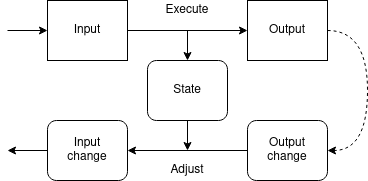

In [10]:
def adjust(func, ins, out, dout):
    """Composable value-aware function adjustment, via reversing execution.

    After execution, propagates loss of output through insides to inputs.
    Make sure that state variables are declared in the order of their usage, the result being the last."""
    if hasattr(func, 'adjust'):
        return func.adjust(ins, out, dout)



_args = None
_dargs = None

class args:
    """Represents args of the currently-called function."""
    def __new__(cls): return cls._singleton
    def call():
        return _args
    def adjust(i,o,do):
        global _dargs
        _dargs = do
args._singleton = Struct(args)



def _merge_adjustments(a,b):
    """When an execution graph node is used N times in an adjusted computation, this is called N-1 times to merge adjustments."""
    if a is None:
        return b
    elif b is None:
        return a
    elif type(a) is list:
        if type(b) is not list and type(b) is not tuple:
            print('Expected list to merge to A, got B:', a, b)
            log('  in node', _get_outer_node())
            assert False, "Not enough list-ness"
        if len(a) != len(b):
            print(a, b, 'in', _get_outer_node()) ##############
            raise TypeError('Lengths are unequal')
        for i in range(len(a)):
            a[i] = _merge_adjustments(a[i], b[i])
        return a
    else:
        return a + b



def wrap_function(f, initial_state):
    """Wrap a function with intro/outro that set up state and cache properly."""
    def execute_func(*args):
        """Change some stuff, execute the wrapped function, then restore that stuff."""
        global _args, _cache, _current_func
        prev_current_func, _current_func = _current_func, execute_func
        prev_cache, _cache = _cache, {}
        prev_args, _args = _args, args
        with SetExecState(execute_func, _cache):
            try: # Call f:
                with state.override(execute_func.states):
                    return f(_current_state_object, *args)
            finally:
                # Restore:
                _current_func = prev_current_func
                _cache = prev_cache
                _args = prev_args

    f.states = {id(execute_func):initial_state}
    for k,v in vars(f).items():
        setattr(execute_func, k, v)
    def execute_func_adjust(ins, out, dout):
        global _dargs
        prev_dargs, _dargs = _dargs, None
        with GetExecState(execute_func) as outs:
            try:
                postorder = _postorder(initial_state)

                indexes = {}
                for i in range(len(postorder)):
                    if isinstance(postorder[i], Struct):
                        indexes[id(postorder[i])] = i

                douts = [None] * len(postorder)
                douts[-1] = dout
                # Assuming that the last defined value is the result.
                #   Ideally, if we have no guarantees,
                #   we'd learn adjustment of every entry point.

                def get_ins(i):
                    n = postorder[i]
                    return [
                        n[j] if id(n[j]) not in indexes
                        else get_out(indexes[id(n[j])])
                            for j in range(1, len(n))]
                def get_out(i):
                    return outs[id(postorder[i])]
                def get_dout(i):
                    return douts[i]
                def set_dins(i, to):
                    # Push `to` to args of a node at `i`:
                    if to is None:
                        return
                    n = postorder[i]
                    if len(n)-1 != len(to):
                        raise TypeError('Wrong count of dins returned from an adjuster')
                    for j in range(1, len(n)):
                        child = n[j]
                        while _fallthrough(child) is not child: child = _fallthrough(child)
                        if id(child) not in indexes:
                            continue
                        in_index = indexes[id(child)]
                        douts[in_index] = _merge_adjustments(douts[in_index], to[j-1])

                for i in reversed(range(len(postorder))):
                    node = postorder[i]
                    if isinstance(node, Struct) and _fallthrough(node) is node:
                        o = adjust(node[0], get_ins(i), get_out(i), get_dout(i))
                        set_dins(i, o)
                return _dargs
            finally:
                _dargs = prev_dargs
    execute_func.adjust = execute_func_adjust
    execute_func.__annotations__ = f.__annotations__
    return execute_func

It's not thread-safe, because I don't know anything about how to write thread-safe code in Python.    
(Reading more, you basically have to use multiple processes. So, global variables should not be a problem.)

There are a lot of moving pieces and global variables, but as long as we almost unfailingly adhere to low-level standards (always restore after changing, don't misplace values, respect the host language) and don't get carried away with implementing things we haven't said we would, we should be able to remove bugs with just a few simple tests.

In [11]:
def exec_then_adjust(loss, func, *args):
    with ExecState():
        result = func(*args)
        print('dins', adjust(func, args, result, loss(args, result)))
        print('  ->', result)
        return result



def test_adj():
    a = args()
    x = Struct(access_many, a, 0)
    y = Struct(access_many, a, 1)
    
    
    @attr(adjust = lambda i,o,do: [5])
    def func1(x):
        return x+5
    
    @attr(adjust = lambda i,o,do: [do * i[1], do * i[0]])
    def func2(u,v):
        return u*v
    
    @attr(adjust = lambda i,o,do: [do / i[1], do / i[0]])
    def func3(u,v):
        return u*v
    
    
    @state(result = Struct(func1, x))
    def test1(st, x):
        return st.result
    
    @state(result = Struct(func2, x, y))
    def test2(st, x, y):
        return st.result
    
    @state(result = Struct(func2, x, Struct(func2, x, y)))
    def test3(st, x, y):
        return st.result
    
    @state(result = Struct(func3, x, y))
    def test4(st, x, y):
        return st.result
    
    @state(result = Struct(func3, x, Struct(func3, x, y)))
    def test5(st, x, y):
        return st.result
    
    exec_then_adjust(lambda args, result: result, test1, 2)
    exec_then_adjust(lambda args, result: result, test2, 1, 5)
    exec_then_adjust(lambda args, result: result, test3, 1, 5)
    exec_then_adjust(lambda args, result: result, test4, 1, 5)
    exec_then_adjust(lambda args, result: result, test5, 1, 5)
test_adj()

dins [5]
  -> 7
dins [25, 5]
  -> 5
dins [50, 5]
  -> 5
dins [1.0, 5.0]
  -> 5
dins [2.0, 5.0]
  -> 5


We can now do what neural networks do, but much slower and more generally.    
Though not yet searching for adjustments, we learned how to do them.

Let's slow down for a second, and relax.    
Say.    
When you were a child, who did you want to be when you grew up?    
I wanted to be.

But enough fooling around.

Let's make a simple neural network.    
Trivia time: neural networks were thought up to mimic human neurons, connecting everything relevant to everything wanted with trivial operations.    
As anyone who has ever looked at a human brain can attest, `tensordot(x, w, (-1,0))` is exactly what's going on there.    
Equivalently, a matrix multiplication of a row vector by weights. Or a nested loop of inputs and outputs, multiplying each input by each weight then summing into the output. These are more verbose.

Add some gradient descent for training, some non-linear operations, and a training loop, and we have:

```bash
pip3 install numpy
pip3 install matplotlib
```

In [12]:
class Past:
    @staticmethod
    def save(x): ...

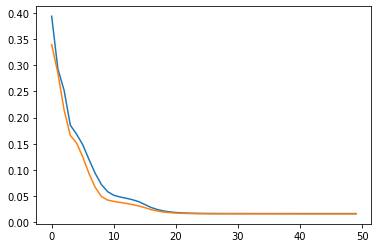

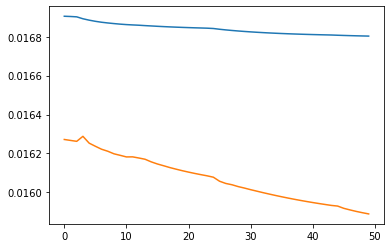

28.23077944800025 s


In [13]:
import numpy as np



class var:
    """A variable that holds and subtracts from a numpy array, for SGD."""
    def __new__(*x): return Struct(*x)
    def call(v, learning_rate):
        v[:] = np.clip(v, -1e4, 1e4)
        return v
    def adjust(i,o,do):
        # Just one learning_rate switch is not the perfection.
        ## Seeing the code, it can be made into anything: momentum with state, a NN, etc.
        var.update(i[0], -i[1] * do)

    def filter(_, __): return False

    deltas = {}
    @staticmethod
    def update(to, delta):
        if id(to) in var.deltas:
            var.deltas[id(to)][1][:] = _merge_adjustments(var.deltas[id(to)][1], delta)
        else:
            var.deltas[id(to)] = [to, delta]
    @staticmethod
    def commit(cancel = False):
        if not cancel:
            for to, delta in var.deltas.values():
                Past.save(to)
                to[:] += delta
        var.deltas.clear()




@attr(adjust = lambda i,o,do: [np.where(i[0] > 0, do, do * 0.001)])
def leaky_relu(v):
    """An operation that introduces discontinuity."""
    return np.where(v > 0, v, v * 0.001)



def _dense_adjust(i,o,do):
    # https://github.com/tensorflow/tensorflow/blob/v2.2.0/tensorflow/python/ops/math_grad.py#L1668
    x,w = i
    if x is None:
        x = np.zeros(w.shape[0]); x[0] = 1.
    if do is None:
        do = np.zeros(w.shape[1])
    dx = np.matmul(do, np.transpose(w))
    dw = np.matmul(np.reshape(x, (w.shape[0], 1)), np.reshape(do, (1, w.shape[1])))
    return dx, dw
@attr(adjust = _dense_adjust)
def dense(x, w):
    """Linearly connects every input to every output.

    The second argument is a random matrix of .shape = (input_size, output_size)."""
    if x is None:
        x = np.zeros(w.shape[0]); x[0] = 1.
    return np.matmul(x, w)
    # If x is always of the shape (n,), then what's below is the same as the line above:
    # return np.tensordot(x, w, axes = (-1,0))



@attr(adjust = lambda i,o,do: (i[0] - i[1], i[1] - i[0]))
def loss2(predicted, got):
    return (predicted - got) * (predicted - got) / 2

def fit_dataset(func, dataset, loss = loss2):
    # This function we've made will likely come in handy later, though it could stand to gain validation.
    test_losses = []
    for io in dataset:
        # Normally, this loop is parallelized by adding a batch dimension to all inputs and outputs.
        ins, intended_out = io[:-1], io[-1] # Overhead.
        out = func(*ins)
        out_loss = loss(out, intended_out)
        test_losses.append(out_loss)
        dout, _ = adjust(loss, (out, intended_out), out_loss, 0)
        adjust(func, ins, out, dout)
    var.commit()
    return sum(test_losses) / len(test_losses), None

def fit_dataset_with_validation(func, dataset, loss = loss2, validation_perc = 0.2):
    # Oh look, I wanted it, and validation appeared by itself.
    import math
    i, size = 0, len(dataset)
    testing = math.floor(size * (1.0 - validation_perc))
    test_losses, validation_losses = [], []
    for io in dataset:
        ins, intended_out = io[:-1], io[-1]
        out = func(*ins)
        out_loss = loss(out, intended_out)
        if testing > 0:
            test_losses.append(out_loss)
            dout, _ = adjust(loss, (out, intended_out), out_loss, 0)
            adjust(func, ins, out, dout)
            testing -= 1
        else:
            validation_losses.append(out_loss)
    var.commit()
    return sum(test_losses) / len(test_losses), sum(validation_losses) / len(validation_losses)



def test_nn(N = 100):
    rng = np.random.default_rng()
    def weights(*shapes):
        return var(rng.normal(0, 1, shapes), 0.01)

    def concat(x, y):
        return np.array([x, y])

    x = Struct(access_many, args(), 0)
    y = Struct(access_many, args(), 1)
    L = Struct(concat, x, y) # (2,)

    L = Struct(dense, L, weights(2,3)) # (3,)
    L = Struct(leaky_relu, L)
    L = Struct(dense, L, weights(3,1)) # (1,)

    L = Struct(access_many, L, 0)

    @state(result = L)
    def nn(st, x, y):
        return st.result


    import matplotlib.pyplot as plt
    dataset = [[x/10, y/10, (x*x + y*y)/100] for x in range(-10, 10) for y in range(-10, 10)]
    random.shuffle(dataset)
    losses, vs = [], []
    for i in range(N):
        l, v = fit_dataset_with_validation(nn, dataset)
        sys.stdout.write(f'Iteration {i+1}/{N}, loss {l}\r')
        sys.stdout.flush()
        if l > 1e10:
            print('exploding — restarting')
            raise RuntimeError()
        losses.append(l)
        vs.append(v)
        if i % 50 == 49:
            plt.plot(losses)
            plt.plot(vs)
            plt.show()
            losses.clear(), vs.clear()



while True:
    # A fancier `test_nn()` with re-trying on RuntimeError.
    from timeit import timeit
    try: print(timeit(test_nn, number=1), 's'); break
    except RuntimeError: continue

In truth, I did feel not a small amount of anxiety at running this code.    
So I took a big break and did another thing.    
For a week.    
Now that it's done, I'm allowed to believe that the only suffering that must not be actively sought out is one that can actually kill.    
If a life doesn't spread its own ways through propaganda, then it won't be a life for much longer.    
So, in the absence of death, invert common sense.

## Computation revisited

Over and over.

Computations in a function are acyclic, but between functions, they may be cyclic to allow recursion.    
So we cannot simply generate everything up-front, and must re-generate function bodies dynamically.

But, the interface we want first:

```python
@state(result = one(0,1))
def func0(st, a: one('x', 'y')) -> one(0,1):
    return st.result

@state(result = one(0,1))
def func1(st, a: real(0,2), b: one(0,1)) -> one(0,1):
    return st.result

@state(result = func1)
def func2(st, a: real(0,1), b: one(0,1)):
    return st.result # Applies `func` 1 or more times.

@state(c = bool())
@examples((0, 0, 0), (1, 1, 100))
def func3(st, a: real(0,1), b: real(0,1)):
    i = 0
    while st.c: # Ideally, connected with numeric ops (NNs) to inputs and local state and randomness.
        i += 1
    return i
```

Having thought about it, I've been thinking about `state` wrong.    
Repeated execution *is* desirable; situations as in `func3` here may arise in search.    
The more fundamental search specification than `state` is `AutoFunc` that connects input to output.    
With it, each attribute of `state` is a separate `AutoFunc`, and the adjustment mapping is a learned `AutoFunc` too.    
Which means that we can execute the pre-computed post-order and be as efficient in execution as in adjustment (also, cache the post-order).

Let's reimplement execution and adjustment in `AutoFunc`:

In [14]:
class AutoFunc:
    """A dynamically-changeable and adjustable function with one input and one output for symmetry."""
    __slots__ = '_struct', '_postorder', '_arg_indexes', '_ctx', '_compiled', '__weakref__'
    # Only ._struct is semantically mutable, via ._set_body; ._postorder/._arg_indexes/._compiled are computed.
    def __init__(self, ins_type, out_type = None, ctx = None, body = None):
        self._struct = None
        self._compiled = None
        self._postorder = None
        self._arg_indexes = None
        self._ctx = [ins_type, *ctx] if ctx is not None else [ins_type]
        assert out_type is None
        self._set_body(body)

    def __call__(self, ins):
        """Function call, with one input.

        Goes through the post-order SSA and executes it, from input to output."""
        ## Things that can also be done:
        ##   bail on exceeding some max time or memory,
        ##   apply any rewriting whenever (if an arbitrary bool is True).
        if self._compiled is not None:
            return self._compiled(ins)
        po, ais = self._postorder, self._arg_indexes
        if po is None:
            s = self._struct
            while _fallthrough(s) is not s: s = _fallthrough(s)
            return s
        outs = [None] * len(po)
        with SetExecState(self, outs):
            global _args
            prev_outer_node = _get_outer_node()
            prev_args, _args = _args, ins
            try:
                for i in range(len(po)):
                    x, ai = po[i], ais[i]
                    if isinstance(x, Struct):
                        if _fallthrough(x) is x:
                            ins = [
                                outs[ai[k]] if ai[k] is not None else x[k+1]
                                for k in range(len(ai))]
                            _set_outer_node(x)
                            outs[i] = x[0].call(*ins) if hasattr(x[0], 'call') else x[0](*ins)
                        else:
                            outs[i] = outs[ai] if ai is not None else _fallthrough(x)
                return outs[-1]
            finally:
                _set_outer_node(prev_outer_node)
                _args = prev_args

    def adjust(self, ins, out, dout):
        """Composable value-aware function adjustment.
        
        Goes through the post-order SSA in reverse and adjusts it, from output to input."""
        if self._compiled is not None:
            return self._compiled.adjust(ins, out, dout)
        po, ais = self._postorder, self._arg_indexes
        if po is None:
            return
        with GetExecState(self) as outs:
            global _dargs
            prev_outer_node = _get_outer_node()
            prev_dargs, _dargs = _dargs, None
            try:
                douts = [None] * len(po)
                douts[-1] = dout

                for i in reversed(range(len(po))):
                    x, ai = po[i], ais[i]
                    if isinstance(x, Struct):
                        if _fallthrough(x) is x:
                            ins = [
                                outs[ai[k]] if ai[k] is not None else x[k+1]
                                for k in range(len(ai))]
                            _set_outer_node(x)
                            to = adjust(x[0], ins, outs[i], douts[i])

                            if to is not None:
                                if len(ai) != len(to):
                                    raise TypeError('Wrong count of dins returned from an adjuster: expected', len(ai), 'but got', len(to), 'in', to)
                                for k in range(len(ai)):
                                    if ai[k] is not None:
                                        douts[ai[k]] = _merge_adjustments(douts[ai[k]], to[k])
                        elif ai is not None:
                            douts[ai] = _merge_adjustments(douts[ai], douts[i])
                return _dargs
            finally:
                _set_outer_node(prev_outer_node)
                _dargs = prev_dargs

    def _set_body(self, struct, po = None, ai = None, compiled = None):
        """Sets the executed structure, pre-filling types and postorder and arg indexes from graph connections."""
        if struct is self._struct:
            return
        if self._struct is not None:
            Past.save(self)
        if po is None and ai is None:
            po = _postorder(struct)
            if po is not None:
                ai = [None] * len(po)
                indexes = {}
                for i in range(len(po)):
                    if isinstance(po[i], Struct):
                        indexes[id(po[i])] = i
                for i in range(len(po)):
                    n = po[i]
                    if isinstance(n, Struct):
                        if _fallthrough(n) is n:
                            ai[i] = [None] * (len(n)-1)
                            for j in range(1, len(n)):
                                arg = n[j]
                                if id(arg) in indexes:
                                    if indexes[id(arg)] >= i:
                                        raise AssertionError('Cycles in computation', po)
                                    ai[i][j-1] = indexes[id(arg)]
                                else:
                                    ai[i][j-1] = None
                        elif id(_fallthrough(n)) in indexes:
                            ai[i] = indexes[id(_fallthrough(n))]
                        else:
                            ai[i] = None
            else:
                ai = None
        self._struct, self._postorder, self._arg_indexes = struct, po, ai
        self._compiled = _compile_af(self) if compiled is None else compiled



# BONUS:
def _compile_af(af):
    # I ended up watching too much physics and making this.
    #   Incidentally, I fixed a latent bug in `adjust`.
    #     Wasting time on loving something is great.
    po, ais = af._postorder, af._arg_indexes
    if po is None:
        return
    # Pass in constants as args of the outer function.
    src, consts, const_names = ['def outer(.·¯):'], {}, {}
    def const(x):
        if id(x) in const_names: return const_names[id(x)]
        name = 'c' + str(len(consts))
        assert name not in consts, "Overwriting a name"
        consts[name] = x
        const_names[id(x)] = name
        return name
    def at(i, s = 's'): return s + '[' + str(i) + ']'
    def assign(i, *strs):
        to = (str(i) + ' = ') if i is not None else ''
        src.append('\n    ' + to + ''.join(strs))
    af_name = const(af)

    # Execute SSA statements:
    src.append(f'\n def inner(ins):')
    src.append(f'\n  s = [None]*{str(len(po))}')
    src.append(f'\n  with {const(SetExecState)}({af_name}, s):')
    src.append(f'\n   prev_outer_node = {const(_get_outer_node)}()')
    src.append(f'\n   try:')
    for i in range(len(po)):
        x, ai = po[i], ais[i]
        if isinstance(x, Struct):
            if x[0] is args:
                assign(at(i), 'ins')
            elif _fallthrough(x) is x:
                ins = [
                    at(ai[k]) if ai[k] is not None else const(x[k+1])
                    for k in range(len(ai))]
                assign(None, const(_set_outer_node), '(', const(x), ')')
                assign(at(i), const(x[0].call if hasattr(x[0], 'call') else x[0]), '(', ','.join(ins), ')')
            else:
                assign(at(i), at(ai) if ai is not None else const(_fallthrough(x)))
    src.append(f'\n   finally:')
    src.append(f'\n    {const(_set_outer_node)}(prev_outer_node)')
    src.append(f'\n  return {at(len(po) - 1)}')

    # Adjust SSA statements:
    src.append(f'\n def inner_adjust(ins, out, dout):')
    src.append(f'\n  dins = None')
    src.append(f'\n  ds = [None]*{str(len(po))}')
    src.append(f'\n  ds[{str(len(po)-1)}] = dout')
    src.append(f'\n  with {const(GetExecState)}({af_name}) as s:')
    src.append(f'\n   prev_outer_node = {const(_get_outer_node)}()')
    src.append(f'\n   try:')
    for i in reversed(range(len(po))):
        x, ai = po[i], ais[i]
        if isinstance(x, Struct):
            if x[0] is args:
                assign('dins', at(i, 'ds'))
            elif _fallthrough(x) is x:
                ins = [
                    at(ai[k]) if ai[k] is not None else const(x[k+1])
                    for k in range(len(ai))]
                assign(None, const(_set_outer_node), '(', const(x), ')')
                # Using `[v1, v2, _, v3] = _merge_adjustments([v1, v2, None, v3], adjust(…))` here.
                #   Could be inlined, but since we don't have access to adjusting funcs and
                #     so can't eliminate tuple creation, that should be JIT's job.
                write_to = '[' + ','.join([at(a, 'ds') if a is not None else '_' for a in ai]) + ']'
                read_from = '[' + ','.join([at(a, 'ds') if a is not None else 'None' for a in ai]) + ']'
                to = f'{const(adjust)}({const(x[0])}, [{",".join(ins)}], {at(i)}, {at(i, "ds")})'
                assign(write_to, f'{const(_merge_adjustments)}({read_from}, {to})')
            elif ai is not None:
                assign(at(ai, 'ds'), f'{const(_merge_adjustments)}({at(ai, "ds")}, {at(i, "ds")})')
    src.append(f'\n   finally:')
    src.append(f'\n    {const(_set_outer_node)}(prev_outer_node)')
    src.append(f'\n  return (dins,)')

    src.append(f'\n inner.adjust = inner_adjust')
    src.append(f'\n return inner')
    src[0] = f'def outer({",".join(consts.keys())}):'

    locs = {}
    exec(''.join(src), { '__builtins__':{} }, locs)
    return locs['outer'](*consts.values())

No paragraph is perfect without edits.    
No code ever works the first time.    
Therefore, we have examples:

In [15]:
def test_af():
    a = args()
    x = Struct(access_many, a, 0)
    y = Struct(access_many, a, 1)

    @attr(adjust = lambda i,o,do: [5])
    def func1(x):
        return x+5
    @attr(adjust = lambda i,o,do: [do * i[1], do * i[0]])
    def func2(u,v):
        return u*v
    @attr(adjust = lambda i,o,do: [do / i[1], do / i[0]])
    def func3(u,v): # Non-gradient heretical thoughts
        return u*v

    test1 = AutoFunc(None, body = Struct(func1, x))
    test2 = AutoFunc(None, body = Struct(func2, x, y))
    test3 = AutoFunc(None, body = Struct(func2, x, Struct(func2, x, y)))
    test4 = AutoFunc(None, body = Struct(func3, x, y))
    test5 = AutoFunc(None, body = Struct(func3, x, Struct(func3, x, y)))

    exec_then_adjust(lambda args, result: result, test1, [2])
    exec_then_adjust(lambda args, result: result, test2, [1, 5])
    exec_then_adjust(lambda args, result: result, test3, [1, 5])
    exec_then_adjust(lambda args, result: result, test4, [1, 5])
    exec_then_adjust(lambda args, result: result, test5, [1, 5])

from timeit import timeit
timeit(test_af, number=1)

dins ([5],)
  -> 7
dins ([25, 5],)
  -> 5
dins ([50, 5],)
  -> 5
dins ([1.0, 5.0],)
  -> 5
dins ([2.0, 5.0],)
  -> 5


0.009840259001066443

Finer than a spring evening.

## General optimization (local search)

While we're near `AutoFunc`, let's add some simple general optimization to it.

Most general case of improvement:     
"*Try random shit and see what works.*"    
If there is no known structure to exploit…    
Then this is the only state-of-the-art possible [[X]](https://arxiv.org/abs/2005.02960).    
(If life advice and code don't agree, then it's code that's not yet good enough. And now and here, they do.)

In code, this may translate to simply `with Past() as shit:` (which should generate evaluation then any change then evaluation, then comparison) and `shit.go_back()`.

Let's implement it then.    
We'll need a unified way of remembering the state before changes: `Past.save(what)`, and use that on every change.    
…In fact, we already do call `Past.save` in `AutoFunc(…)._set_body(…)` near the beginning. Huh. What a coincidence.    

In [16]:
_checkpoints = []

class Past:
    """
    A context manager that preserves a checkpoint of mutable state that can be went back to.

    Classes should define .past_save and .past_go_back if they have state that can be changed.

    Usage examples:

        # Try and maybe go back:
        evaluate()
        m1 = measure()
        with Past() as shit:
            change()
            evaluate()
            m = measure()

            if m < m1:
                shit.go_back()

        # Train and make/restore checkpoints:
        with Past() as p1:
            with Past() as p2:
                with Past() as p3:
                    m1 = m2 = m3 = measure()
                    while not stopping():
                        change_hyperparameters()
                        train()
                        m = measure()
                        if m < m1: p1.go_back()
                        elif m < m2: p2.go_back()
                        elif m < m3: p3.go_back()
                        else:
                            if condition1(): p1.update()
                            elif condition2(): p2.update()
                            elif condition3(): p3.update()
    """
    __slots__ = ['cp']
    def __enter__(self):
        self.cp = {}
        _checkpoints.append(self.cp)
        return self
    def __exit__(self,x,y,z):
        assert _checkpoints[-1] is self.cp
        _checkpoints.pop()

    def update(self):
        """Makes the remembered state the current state.

        Same as creating a new Past and only using that from this point on."""
        self.cp.clear()
    def go_back(self):
        """Makes the current state the remembered state."""
        for z in self.cp.values():
            if z is ...: continue
            Past.save(z[0])
            if hasattr(z[0], 'past_go_back'):
                z[0].past_go_back(z[1])
            else:
                z[0][:] = z[1]
        self.cp.clear()

    @staticmethod
    def save(what):
        """Call this before changing a sequence, to allow it to be restored in `past.go_back()`."""
        saving = None
        for cp in _checkpoints:
            if id(what) not in cp:
                if saving is None:
                    if hasattr(what, 'past_save'):
                        saving = what, what.past_save()
                    else:
                        # I initially used what[:] here and made a note to pass in np.copy as the second arg if numpy,
                        #   but what.copy() turns out to exist on both python3 lists and numpy arrays.
                        # I edit so much that I must seem like some sort of genius.
                        saving = what, what.copy()
                cp[id(what)] = saving
        return what
    @staticmethod
    def new(what):
        """Call this when constructing an object, to prevent it from being saved in already-existing pasts."""
        for cp in _checkpoints:
            if id(what) not in cp:
                cp[id(what)] = ...
        return what



AutoFunc.past_save = lambda af: (af._struct, af._postorder, af._arg_indexes, af._compiled)
AutoFunc.past_go_back = lambda af, saved: af._set_body(*saved)

The ability to constantly do random dumb shit, free will, is very important.    
Making a system through only that is the only way it can learn to counteract any malicious shit.    
It's called self-play in games. But I call it mastering the improvement of structured executable state, to the point where it's easier to use than not.    
Leaving in random twists of thought can make texts more alive, too.

Still, life is a clunky dinosaur.    
In it, adding the right thing is easy, but removing all the wrong things is nigh impossible.    
Code is much easier than that. You just write unit tests and test every part as it's created.

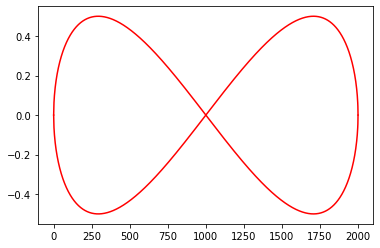

[10] [2]
[1] [2]
[5] [6]
[1] [2]
[7] [2]
[20] [2]
[7] [30]


In [17]:
# Actually, screw testing that code, it's too simple.
import matplotlib.pyplot as plt
plt.plot([ math.sqrt((i/1000)*(i/1000) * (1 - (i/1000)*(i/1000))) for i in range(-1000, 1001)], 'r')
plt.plot([-math.sqrt((i/1000)*(i/1000) * (1 - (i/1000)*(i/1000))) for i in range(-1000, 1001)], 'r')
plt.show()

# Actually, screw screwing, let's test it.
def test_past():
    a, b = [1], [2]

    with Past() as shit:
        Past.save(a);  a[0] = 10
        print(a, b) # [10] [2]
        shit.go_back()
        print(a, b) # [1] [2]
        Past.save(a);  a[0] = 5
        Past.save(b);  b[0] = 6
        print(a, b) # [5] [6]
        shit.go_back()
        print(a, b) # [1] [2]
        Past.save(a);  a[0] = 7
        shit.update()
        Past.save(a);  a[0] = 8
        shit.go_back()
        print(a, b) # [7] [2]

    with Past() as p1:
        with Past() as p2:
            Past.save(a);  a[0] = 20
            p1.update()
            p2.go_back()
            Past.save(b);  b[0] = 30
            p2.update()
            p1.go_back()
            print(a, b) # [20] [2]
            p2.go_back()
            print(a, b) # [7] [30]
            # Yep, bugs found and fixed. Code is not as simple anymore.
            #   Multi-past manipulations are handled now.
    
test_past()

Eventually, we'd like this `Past` optimizer to optimize optimizers.    
But usage examples of `Past` don't have a static structure.    
"Optimizer" isn't some class with well-defined construction, it's just whatever code improves other code.    
It's vast, boundless, and unknowable — just how I like females of my species.

We'll want to generate expressions (bodies inside `with Past as p: ...`) that both know of functions (`p.update()`/`p.go_back()`) and generate a sequence (of change/evaluate/check, here; probably via the `last(*types)` type that returns the last value when evaluated).    
We'll possibly need a thing in a context to be able to say that it can create any value, or specify an arbitrary struct filter, maybe saying that its `.type` is `...`.

Now, the changes for `Past` to optimize…

## Composition in a typed context

Stop right there, criminal scum!    
Trying to get to graph rewriting without the classic of program search, generation of values of a type? Easy pickings? I see right through you.    
Pick one: a toll of separation, or time in complexity prison?    
Okay, I'll pay up.

To be clear, a type is a pure transformation from an expression (`AutoFunc(…)._struct`) to a thing that should denote all its possible outputs.

From value to type: `Context.type(value)`, listening to `.type` for functions and caching results.    
From type to value: `Context.enum(type)`, listening to `.filter` if defined, or to `.enum` (the first can do slow dependent types without knowing internal details of `Context`, the second can do union types and give max extensibility via its branch-to-data).

In addition, after creating a value, we may want to remember it so that we can return it from a future request of generation.    
Meaning `Context.add(value)`.

But we can't infinitely add all possible values forever.    
Do we make a function for clearing the remembered context, or make a context manager?    
Changing the context entirely would allow the same types to mean different things in different places.    
`with Context(*values):` would serve us well.

And contexts being iterable won't cause pain.

In [18]:
class Context:
    """
    A context of typed values.

    With it, can get the type of a value or enumerate values of a type,
    or remember that a found value exists, or enumerate all values.
    Only one context can be active at the same time (`with Context(…):`).
    """
    @staticmethod
    def typeof(value):
        """Gets the type of a value in the current context.

        Defers to `.typeof(value)` if defined on a `Struct`, else returns `value`."""
        assert _current_context is not None, 'Use only inside `with Context():`'
        return _current_context._typeof(value)

    @staticmethod
    def add(value):
        """Adds to values of a type in the current context.

        Iterates over `.add(value)` if defined on a `Struct`, else adds to values of `id(type)`.
        Adding a Context adds all values in it.

        Same-head `Struct` types are put into the same bucket.
        Make the head define `.filter` to control which items in a bucket are enumerated."""
        assert _current_context is not None, 'Use only inside `with Context():`'
        return _current_context._add(value)

    @staticmethod
    def enum(Type):
        """Iterates over intermediate values of a type in the current context.

        Before being used, these intermediate values must go through `Context.finish`.

        If the type defines `.filter(value)` that returns True if a value is fit for being enumerated,
        filters values in the type's bucket.
        If the type defines `.enum()` and can enumerate/create values itself, also defers to that."""
        assert _current_context is not None, 'Use only inside `with Context():`'
        return _current_context._enum(Type)

    @staticmethod
    def finish(intermed, Type):
        """Turns an intermediate value into a usable value of a type."""
        if _defines(intermed, 'finish'):
            return _defines(intermed, 'finish')(intermed, Type)
        return intermed

    @staticmethod
    def get(Type):
        """Returns just one value of a type in the current context."""
        opts = []
        for v in Context.enum(Type):
            opts.append(v)
            if len(opts) > 64: break
        if not len(opts):
            raise _EmptyType("No instances of the type", Type)

        return Context.finish(Context.pick(opts), Type)

    @staticmethod
    def pick(options):
        """Picks any one item of an array."""
        ## Could instead compute some learned measure for each option, then pick the best or sample.
        return random.choice(options)

    @staticmethod
    def type(value, Type):
        """Assigns a different type to a value. Should be called before adding that value to the context.

        Nodes that rely on `Context.type` to set their type will be impossible to dynamically re-generate.
        Example: `Context.type(args(), many(1,2,3))`."""
        ctx = _current_context
        assert ctx is not None, 'Use only inside `with Context():`'
        vt = ctx._valueid_to_type
        prev_type = vt.get(id(value))
        vt[id(value)] = Type
        ctx._add(value, prev_type)
        return value

    @staticmethod
    def _current():
        """Returns the current context."""
        return _current_context

    def _typeof(self, value):
        while _fallthrough(value) is not value: value = _fallthrough(value)
        # Cache, else defer to .typeof:
        vt = self._valueid_to_type
        if id(value) in vt:
            return vt[id(value)]
        f = _defines(value, 'typeof')
        if f is not None:
            i = id(value)
            vt[i] = None
            vt[i] = f(value)
            # id(value) may be re-used if value is freed, so that must clear the cache.
            #   (Assuming that types outlive the context, and do not require clearing.)
            weakref.finalize(value, _clear_dict_key, self._valueid_to_type, id(value))
            return vt[i]
        return value

    def _add(self, value, prev_type = None):
        tv = self._typeid_to_values
        if not isinstance(value, Context):
            # Add or move value and user-defined .additions to appropriate spot/s:
            was_present = id(value) in self._valueid_to_type
            Type = self._typeof(value)
            if _defines(Type, 'add'):
                for v in _defines(Type, 'add')(value):
                    self._add(v)

            tid = _typeid(Type)
            Past.save(self)
            if prev_type is not None and _typeid(prev_type) != tid and tid in tv:
                tv[tid].pop(id(value), None)
            if Type is not None:
                if tid not in tv:
                    tv[tid] = {}
                tv[tid][id(value)] = value
        else:
            # Copy everything in the context:
            Past.save(self)
            self._valueid_to_type.update(value._valueid_to_type)
            for tid, vs in value._typeid_to_values.items():
                if tid not in tv:
                    tv[tid] = {}
                tv[tid].update(vs)
        return value

    def _enum(self, Type):
        # Yield (possibly .filtered) same-head-type values, then user-defined enumeration.
        if Type is ...:
            yield from self
            return
        tv = self._typeid_to_values
        tid = _typeid(Type)
        if tid in tv:
            f = _defines(Type, 'filter')
            if f is not None:
                for v in tv[tid].values():
                    if f(Type, v):
                        yield v
            elif tid in tv:
                yield from tv[tid].values()
        if _defines(Type, 'enum'):
            yield from _defines(Type, 'enum')(Type)

    def _clear(self):
        self._typeid_to_values.clear()
        self._valueid_to_type.clear()

    def __iter__(self):
        seen = set()
        for vs in self._typeid_to_values.values():
            for v in vs.values():
                if id(v) not in seen: yield v
                seen.add(id(v))

    def past_save(self):
        return self._typeid_to_values.copy(), self._valueid_to_type.copy()
    def past_go_back(self, saved):
        tv, vt = self._typeid_to_values, self._valueid_to_type
        tv.clear();  tv.update(saved[0])
        vt.clear();  vt.update(saved[1])

    def __init__(self, *values):
        self._prev_cc = None
        self._valueid_to_type = {}
        self._typeid_to_values = {}
        Past.new(self)
        with self:
            for v in values: self._add(v)

    def __enter__(self):
        global _current_context
        assert self._prev_cc is None # We remember none
        self._prev_cc, _current_context = _current_context, self
        return self

    def __exit__(self,x,y,z):
        global _current_context
        assert _current_context is self
        _current_context, self._prev_cc = self._prev_cc, None

    __slots__ = '_typeid_to_values', '_valueid_to_type', '_prev_cc'

_current_context = None

def _clear_dict_key(d, k):
    if k in d: del d[k]

def _typeid(Type): return id(Type) if not isinstance(Type, Struct) else id(Type[0])

def _defines(d, k):
    if isinstance(d, Struct): d = d[0]
    return getattr(d, k) if hasattr(d, k) else None

class _EmptyType(RuntimeError):
    """Type of exceptions that signals that generating an instance required an instance of an empty type."""

I enjoy Python's context managers. Much prettier than init+`try`+`finally` everywhere.    
I don't enjoy Python's string-based duck typing. The more precise approach is object-id-based definition, lacking all potential for name collision, but I'm not willing to add an extra line and an extra private method for each definition, and extra syntactic effort for access.    
This night, I dreamt of being a pigeon.

If nothing is done with knowledge, then it wasn't actually learned. Let's do some thing with it:

In [19]:
def test_ctx():
    with Context(1, 2, 3):
        print(Context.get(2))

test_ctx()

2


Remarkable.    
Just the functionality I've always missed.    
For real though, let's add types to functions.

sample: [<function test_compose.<locals>.initX at 0x7fe5a460e8b0>] typed x
40
110
1100
1110
1200
2000
10100
11000
11010


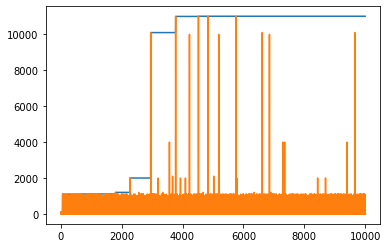

best body: [<function test_compose.<locals>.f at 0x7fe5a460e790>, [<function test_compose.<locals>.g at 0x7fe5a460e820>, [<function test_compose.<locals>.g at 0x7fe5a460e820>, [<function test_compose.<locals>.f at 0x7fe5a460e790>, [<function test_compose.<locals>.g at 0x7fe5a460e820>, [<function test_compose.<locals>.g at 0x7fe5a460e820>, [<function test_compose.<locals>.initX at 0x7fe5a460e8b0>], [<function test_compose.<locals>.initY at 0x7fe5a460e940>]], [<function test_compose.<locals>.initY at 0x7fe5a460e940>]], [<function test_compose.<locals>.initY at 0x7fe5a460e940>]], [<function test_compose.<locals>.initY at 0x7fe5a460e940>]], [<function test_compose.<locals>.initY at 0x7fe5a460e940>]], [<function test_compose.<locals>.initY at 0x7fe5a460e940>]]


In [20]:
class compose:
    """
    A function decorator for specifying input and output types, for composition. Modifies the function.
    """
    def __init__(self, *ins, out = None):
        self.ins = ins
        self.out = out

    def __call__(self, f):
        assert not hasattr(f, 'typeof'), "Don't forget that `compose(…)(f)` modifies f"
        ins, out = self.ins, self.out
        if out is None:
            # Extract ins/out from signature. Assuming that all params are positional.
            assert len(ins) == 0, "If `out` was not specified, inputs will be inferred too"
            import inspect
            sig = inspect.signature(f)
            ins = [_pythons_to_ours(sig.parameters[p].annotation) for p in sig.parameters]
            out = _pythons_to_ours(sig.return_annotation)
        f._compose_signature = ins, out

        f.typeof = _compose_typeof
        f.filter = _compose_filter
        f.finish = _compose_finish
        if _defines(out, 'add') is not None:
            f.add = _compose_add

        return f

    __slots__ = 'ins', 'out'

def _compose_typeof(x):
    if callable(x): # Ensure the result type is visible to enumeration.
        if not hasattr(x, '_compose_signature'): return None
        return Context.typeof(x._compose_signature[-1])
    # Check shape, then check input types, then compute/return output type.
    assert isinstance(x, Struct)
    ins, out = x[0]._compose_signature
    if len(x)-1 != len(ins): return None
    for i in range(len(ins)):
        # This could be compiled to push the overhead of runtime checking to compile-time.
        # In some newer languages, the word "staging" could be used with the same meaning.
        # Both are crutches for the lack of partial evaluation, which itself
        #   would benefit from learning, to avoid exponential inlining
        #     (and so is best suited for a JIT compiler).
        #       Understandable today. Not judging.
        if hasattr(ins[i], 'filter'):
            if not ins[i].filter(x[i+1]):
                return
        else:
            if Context.typeof(x[i+1]) != ins[i]:
                return
    if callable(out): return out(x)
    return Context.typeof(out)
def _compose_filter(enum, v):
    if callable(v) and v is not enum: return False
    return _compose_typeof(v) is not None
def _compose_finish(f, _):
    # Generate all inputs in any order (though here, first-is-first), and create the struct.
    if not callable(f): return f
    ins, _ = f._compose_signature
    return Context.add(Struct(f, *(Context.get(ins[i]) for i in range(len(ins)))))
def _compose_add(f):
    _, out = _defines(f, '_compose_signature')
    a = _defines(out, 'add')
    if a is not None:
        for v in a(f):
            yield v

def _pythons_to_ours(x):
    if not isinstance(x, Struct):
        if isinstance(x, list) or isinstance(x, tuple): return many(*x)
    if x is inspect.Parameter.empty: return ...
    return x



def test_compose():
    @compose('x', 'y', out = 'x')
    def f(x, y):
        return x + y

    @compose()
    def g(a:'x', b:'y') -> 'x':
        return a * b

    @compose()
    def initX() -> 'x':
        return 1
    @compose()
    def initY() -> 'y':
        return 10
    @compose()
    def initZ() -> 'z':
        return 100

    with Context(f, g, initX, initY, initZ):
        s = Context.get('x')
        print('sample:', s, 'typed', Context.typeof(s))


    # Maximize output when executed. (Random search, starting anew each time.)
    with Past() as shit:
        with Context(f, g, initX, initY, initZ):
            best, every = [], []
            af = AutoFunc(None)
            best_out = None
            for _ in range(10000):
                # Note that creating bodies adds each node to the context, decreasing diversity,
                #   so re-creating the context each time would easily push best output to 1e12+.
                body = Context.get('x')
                af._set_body(body)
                out = af(None)
                if best_out is None or out > best_out:
                    best_out = out
                    shit.update()
                    print(out)
                best.append(best_out)
                every.append(out)
            import matplotlib.pyplot as plt
            plt.plot(best)
            plt.plot(every)
            plt.show()
            shit.go_back()
            print('best body:', af._struct)



test_compose()

It's not advanced enough to create functions in inputs/output.    
Nor does it integrate with union/product types (future me, get on that).    
Nor does it handle failures to generate (the best "exactly when" is unknowable).    
But it's good enough for getting precise types from A to B with zero inconsistencies.    
That means that I too cannot make trivial bugs now.

Until arbitrary runtime learning is super easy, aiming for more than "good enough" is a mistake anyway.    
(`Context.get` in particular could use infinite improvement.)

---

Future me here. Product types (`many(1,2,3)`) can be satisfied with iterating over user-defined values. Wired that up.

This whole section has been mostly about directly satisfying mandates without deeper thought.

I'm uncertain of its future, but I know no better.

## Rewriting sequel

Our representation of computation looks good, so let's rewrite my incomplete rewriting.

There are a few new features that we'd like to handle.    
Namely, typed contexts and adjusting present in an `AutoFunc` (and the function `_merge_adjustments`).    
But also, while we're at it, it would be nice to look both ways when crossing the graph street, and allow accumulating values on descent, not just ascent.    
And, not rewrite the past of histories.

But how can we do that?

Let's begin from the end.

Our `_postorder` already does not go into pasts, so re-using that seems useful.

Our olden ascent is walking the post-order left-to-right.    
The new descent is walking the post-order right-to-left.    
Descent: `(graph_node, descent_estimate) -> (ascent_message, descent_estimate)`.    
Ascent: `(graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate)`.    
`descent_estimate`, `ascent_message`, `ascent_estimate` are variables that would need arrays in the state of rewriting.    
All possible data flow dependencies now have adjustable communication channels; the full graph is handled, local neighborhood first.    
An *everything* would be achievable in this component.

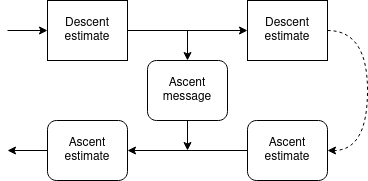

We do need to merge `descent_estimate`s of parents and `ascent_estimate`s of children in an order-independent manner, with `_merge_adjustments`.

To handle generation in typed contexts, we want to wrap everything `with Context(base_ctx): …` and `Context.add(…)` each node when we've finished it (first add the old in the descent, then add the new in the ascent).

Adjusting is execution backwards.    
We'll need to return the final `ascent_estimate` from rewriting too if we hope to optimize it. It can represent how well the graph does on some measure, then optimization means computing the difference and passing it to `adjust`.    
Firstly, adjust ascent right-to-left.    
Then adjust descent left-to-right.

I would like to take a moment to discuss virtual cycles in computation ("edges" that refer to a past/future value).    
What we can do is mark a value with a "can assign X to this" or "can adjust this into X" type, both of which have define `.add` that the special result type will try to enumerate instances of, to be passed into an `assign` or `adjust` function.    
But not now. Now, we're in "implement low-level infrastructure" mode.

In [21]:
def _rewrite_adjust(ins, out, dout):
    # Python's decision to disallow proper functions in expressions is dumb.
    af, descend, ascend, *_ = ins
    po, ai = af._postorder, af._arg_indexes
    with GetExecState(rewrite) as st:
        descent_estimates, ascent_messages, ascent_estimates, nodes_become = st
        ddescent_estimates, dascent_messages, dascent_estimates = [None]*len(po), [None]*len(po), [None]*len(po)

        # Not sure why anyone would want to communicate to this all-or-nothing slot, but it's there just in case.
        dnodes_become = [None]*len(po)

        dascent_estimates[-1] = dout

        for i in reversed(range(len(po))):
            # Re-collect ascent estimate from children:
            post, ae = _merge_from_children(po[i], ai[i], ascent_estimates, po, nodes_become)

            # Adjust ascent and give estimate to children:
            ins = post, ae, ascent_messages[i]
            out = nodes_become[i], ascent_estimates[i]
            dout = dnodes_become[i], dascent_estimates[i]

            # Reverse (graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate).
            dnb, dae, dam = adjust(ascend, ins, out, dout)

            _give_to_children(po[i], ai[i], dnodes_become, dnb)
            _give_to_children(po[i], ai[i], dascent_estimates, dae)
            dascent_messages[i] = dam

        if descend is not None:
            for i in range(len(po)):
                # Re-collect descent estimate & its change from children:
                _, de = _merge_from_children(po[i], ai[i], descent_estimates, po, nodes_become, False)
                _, dde = _merge_from_children(po[i], ai[i], ddescent_estimates, po, nodes_become, False)

                ins = po[i], descent_estimates[i]
                out = ascent_messages[i], de
                dout = dascent_messages[i], dde

                # Reverse (graph_node, descent_estimate) -> (ascent_message, descent_estimate).
                _, ddescent_estimates[i] = adjust(descend, ins, out, dout)



@attr(adjust = _rewrite_adjust)
def rewrite(af, descend, ascend, de_initial = None, ae_initial = None, am_initial = None):
    """
    Rewrites the body of an AutoFunc in-place. Returns the final ascent estimate.

    `descend` should be None or (graph_node, descent_estimate) -> (ascent_message, descent_estimate).
    `ascend` should be (graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate).
    `id(graph_node[0])` can be pattern-matched in these. `graph_node` will always be a `Struct`.
    `de_initial`/`ae_initial`/`am_initial` are `descend`'s/`ascend`'s non-accumulated estimates and message.

    Intended usage is to put neural networks as descent/ascent estimates/messages to predict the overall estimate,
    and repeatedly rewrite nodes in any way while preserving their `history` (and going back at any time),
    where each executable function should have several rewriting rules for it.
    """

    base_ctx, po, ai = af._ctx, af._postorder, af._arg_indexes
    descent_estimates = [None]*len(po)
    ascent_messages = [None]*len(po)
    ascent_estimates = [None]*len(po)
    nodes_become = [None]*len(po)

    if base_ctx is not None and not isinstance(base_ctx, Context):
        base_ctx = Context(*base_ctx)
    with Context(base_ctx):
        with SetExecState(rewrite, (descent_estimates, ascent_messages, ascent_estimates, nodes_become)):
            if descend is not None:
                for i in reversed(range(len(po))):
                    # Descend:
                    de = descent_estimates[i]
                    de = de if de is not None else de_initial
                    ascent_messages[i], descent_estimate = descend(po[i], de)
                    # Give descent estimate to children:
                    _give_to_children(po[i], ai[i], descent_estimates, descent_estimate)
                    Context.add(po[i])

            for i in range(len(po)):
                # Collect ascent estimate from children:
                post, ae = _merge_from_children(po[i], ai[i], ascent_estimates, po, nodes_become)
                am = ascent_messages[i]
                # Ascend:
                ae = ae if ae is not None else ae_initial
                am = am if am is not None else am_initial
                nodes_become[i], ascent_estimates[i] = ascend(post, ae, am)
                Context.add(nodes_become[i])

            af._set_body(nodes_become[-1])
            return ascent_estimates[-1]



def _merge_from_children(n, arg_indexes, estimates, old, new, create_post = True):
    """Returns the changed node (with changed children too) and estimate."""
    if not isinstance(n, Struct): return n, None
    ae = None
    post, changed = n, False
    if _fallthrough(n) is n:
        for j in range(1, len(n)):
            ind = arg_indexes[j-1]
            if ind is not None:
                ae = _merge_adjustments(ae, estimates[ind])
                if create_post and new[ind] is not old[ind]:
                    if not changed: post = Struct(*n)
                    post[j] = new[ind]
                    changed = True
        if ae is not None:
            ae = ae / (len(n)-1) # Hopefully reduce gradient explosions.
    elif arg_indexes is not None:
        ae = estimates[arg_indexes]
    return post, ae

def _give_to_children(n, arg_indexes, estimates, add):
    if not isinstance(n, Struct): return
    if add is None or len(n) == 1: return
    add = add / (len(n)-1) # Hopefully reduce gradient explosions.
    if _fallthrough(n) is n:
        for j in range(1, len(n)):
            ind = arg_indexes[j-1]
            if ind is not None:
                estimates[ind] = _merge_adjustments(estimates[ind], add)
    elif arg_indexes is not None:
        estimates[arg_indexes] = _merge_adjustments(estimates[arg_indexes], add)

Code is very clean, as long as the necessary ugly parts are extracted off sight.

How would you like to test its mettle, milord?

Only two ways present themselves to me.    
One: a generic rewriting rule that re-generates instances of the same type (with history), to act as the random change of local search. When given the "create maximum-output structure" problem, this should easily create outputs much greater than 10¹².    
Two: learning a recursive neural network, without changing the nodes. When given the "predict the output of this structure" problem, and repeatedly fitted on a big dataset of randomly-created structures, it won't learn the jagged peaks well, but the loss should at least go down.

Your sight is vast for sure, but mine is limited by what I've done.    
And will do:

1
10
100
1000
1130
11030
2200030
21100030
120100030
1120100030
2010000030
211010000030
311010000030
1301010000030
13001010000030
112001010000030
2201201010000030
10101201010000030
110101201010000030
1200101201010000030
1300101201010000030
3100101201010000030
5000101201010000030
11023000101201010000030
110023000101201010000030
410023000101201010000030


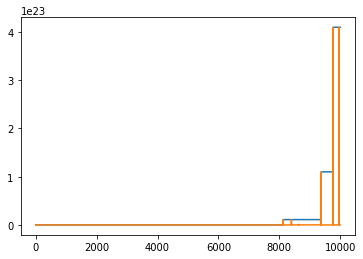

best body: [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [<function test_rs_1.<locals>.g at 0x7fe5a4618940>, [<function test_rs_1.<locals>.f at 0x7fe5a4618ee0>, [

In [22]:
def test_rs_1():
    def regen_t(node, ae, am):
        # (graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate)
        if not isinstance(node, Struct):
            return node, None
        becomes = node

        if random.randint(0,9) == 0:
#             if node[0] is History:
#                 i = random.randint(1, len(node)-2)
#                 becomes = node[1] if i == 1 else Struct(*node[:i+1])
#                 if random.randint(0,9) == 0:
#                     becomes = history(node, becomes)
#             else:
                t = Context.typeof(node)
                becomes = Context.get(t)
#                 becomes = history(node, becomes)

        return becomes, None

    @compose()
    def f(x:'x', y:'y') -> 'x': return x + y
    @compose()
    def g(x:'x', y:'y') -> 'x': return x * y

    @compose()
    def initX() -> 'x': return 1
    @compose()
    def initY() -> 'y': return 10
    @compose()
    def initZ() -> 'z': return 100



    # Maximize output when executed. (Local search, going back sometimes.)
    with Past() as shit:
        with Context(f, g, initX, initY, initZ) as ctx:
            best, every = [], []
            af = AutoFunc(None, None, Context(ctx), body = Struct(initX))
            best_out = None
            for _ in range(10000):
                rewrite(af, None, regen_t)
                out = af(None)
                if best_out is None or out > best_out:
                    best_out = out
                    shit.update()
                    print(out)
                elif random.randint(0,9) == 0:
                    shit.go_back()
                best.append(best_out)
                every.append(out)
            import matplotlib.pyplot as plt
            plt.plot(best)
            plt.plot(every)
            plt.show()
            shit.go_back()
            print('best body:', af._struct)

test_rs_1()

What tragedy! Leaving a trail of history makes code barely reach outputs of 10¹⁰.    
I thought for sure… But, no, signs were visible even then, when I paid the thoughts "this doesn't represent 'when' to go back, nor learn the best" no heed.    
But, if everything is generated from a type anyway, there's no harm in just re-generating from a node's type.    
`many`/`one`/`last` and such are not implementation details but tools, and so *should* be fine.

Eventually, it would be nice to see what happens if our rewrites preserve variables in neural networks (so there is, on average, less learning between rewrites) (explicitly `Past.save`ing variables, of course) when performing local search on their structures. And if we have rewrites to expand and contract weight matrices, and change variables' adjustment methods while preserving their data.    
But, speaking of neural networks:

Learning rate 1.5279325773139195e-05, best loss 11.3832695245247:


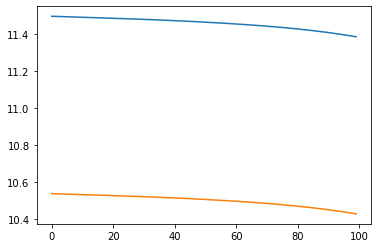

435.7559230659972 s


In [23]:
class _SingleFunc:
    """A thin decorator that wraps many inputs in one tuple."""
    def __init__(self, f): self.f = f
    def __call__(self, *x):
        return self.f(x)
    def adjust(self, i,o,do):
        return adjust(self.f, (i,), o, do)[0]

    def regenerate(self, up, down):
        regenerate(self.f, up, down)

    __slots__ = 'f',



@attr(adjust = lambda i,o,do: np.split(do, [i[0].size]))
def concat(x, y): return np.concatenate((x, y))


def renn(nn, feature_size = 5):
    """Creates a recursive neural network that takes a graph (AutoFunc) and outputs a single number."""
    def descent():
        # (_, descent_estimate) -> (ascent_message, descent_estimate).
        a = args()
        de = Struct(access_many, a, 1)
        am, de2 = nn(de, feature_size, feature_size), nn(de, feature_size, feature_size)
        result = many(am, de2)
        return _SingleFunc(AutoFunc(None, None, body = result))
    def ascent():
        # (_, ascent_estimate, ascent_message) -> (_, ascent_estimate).
        a = args()
        node = Struct(access_many, a, 0)
        ae = Struct(access_many, a, 1)
        am = Struct(access_many, a, 2)
        both = Struct(concat, ae, am)
        ae2 = nn(both, feature_size*2, feature_size)
        result = many(node, ae2)
        return _SingleFunc(AutoFunc(None, None, body = result))

    def matcher(storage, default):
        """Creates a function that goes to a branch, dynamically creating it if needed.
        The branch is determined by the first arg's head."""
        def in_storage(s):
            Id = id(s[0] if isinstance(s, Struct) else s)
            if Id not in storage:
                storage[Id] = default()
            return storage[Id]
        def func(*ins): return in_storage(ins[0])(*ins)
        func.adjust = lambda i,o,do: adjust(in_storage(i[0]), (i,), o, do)
        return func
    initial = np.zeros(feature_size)
    initial[0] = 1.
    features = Struct(rewrite, args(), matcher({}, descent), matcher({}, ascent), None, initial)
    # Wouldn't it be nice if all these calls to `nn` can be automatically inlined and grown/tweaked as needed?
    final = nn(features, feature_size, 1)
    return AutoFunc(None, None, body = Struct(access_many, final, 0))



def test_rs_2():
    rng = np.random.default_rng()
    learning_rate = [math.pow(10, random.uniform(-3, -5))]
    def weights(*shapes):
        return var(rng.normal(0, .3, shapes), Struct(access_many, learning_rate, 0))

    def nn(input_struct, input_size, output_size, hidden_layers = 1, hidden_size = 10):
        # vector[input_size] -> vector[output_size].
        L, sz = input_struct, input_size
        for _ in range(hidden_layers):
            # This loop is so rigid. A prison for the self-modification light that made it.
            L = Struct(dense, L, weights(sz, hidden_size))
            L = Struct(leaky_relu, L)
            sz = hidden_size
        return Struct(dense, L, weights(sz, output_size))



    @compose()
    def initX() -> 'x': return 1
    @compose()
    def initY() -> 'y': return 10
    @compose()
    def initZ() -> 'z': return 100
    @compose()
    def f(x:'x', y:'y') -> 'x': return x + y
    @compose()
    def g(x:'x', y:'y') -> 'x': return x * y

    dataset = []
    for _ in range(1000):
        with Context(initX, initY, initZ, f, g):
            # Lots of duplicate bodies.
            af = AutoFunc(None, None, body = Context.get('x'))
            out = af(None)
            dataset.append((af, math.log(out)))
            # Only actual structural learning could have put this math.log here.



    import matplotlib.pyplot as plt
    losses, validation_losses = [], []
    def plot():
        print(f'Learning rate {learning_rate[0]}, best loss {min(losses)}:')
        plt.plot(losses)
        plt.plot(validation_losses)
        plt.show()
        losses.clear(), validation_losses.clear()
    func = renn(nn)
    prev_l, prev_dl = None, None
    try:
        N = 100
        for i in range(N):
            l, v = fit_dataset_with_validation(func, dataset)
            sys.stdout.write(f'Iteration {i+1}/{N}, loss {l}\r')
            sys.stdout.flush()

            dl = l - prev_l if prev_l is not None else None
            if l > 1e5 or not np.isfinite(l) or dl is not None and not np.isfinite(dl):
                # Watching the loss go down is satisfying,
                #   but watching it go from nan to nan and restarting manually is not.
                if i > 10:
                    losses.pop()
                    validation_losses.pop()
                    plot()
                print(f'Exploding after {i} epochs ⇒ restarting.')
                raise RuntimeError()
            prev_l, prev_dl = l, dl

            losses.append(l), validation_losses.append(v)
            if i % 100 == 99:
                plot()
    except KeyboardInterrupt:
        plot()
        raise

while True:
    try: print(timeit(test_rs_2, number=1), 's'); break
    except RuntimeError: continue

# Full disclosure. Ugh.
#   Compared to my language, Python's error messages really are garbage.
#   I need to do so many print statements to find the values that cause the errors.
#   All because Python can't fearlessly print arbitrary values. Text is garbage. Terminal is garbage.
# I also don't like the "after days of work, consume all memory and force the OS to swap,
#   which forces me to reboot if I want to do anything this day" feature of Python.

Curves now do go down sometime during their lifespan, and I once got the loss to `0.370…`, so, mission accomplished?    
Could probably tinker until it's not (as) unstable, but it's the computer that should (be able to) try all these choices, not me.

These soft channels (`ascent_estimate`/…) are usable for predicting and learning properties of DAGs, but they are useless for adjusting probability distributions of picked nodes.    
If we want *that*, we would need to compute the difference between the DAG we have and the DAG we want, expressed via lists of particular rewrite rules attached to nodes that they rewrite.    
However, as far as I know, [graph homomorphism is NP-hard](https://en.wikipedia.org/wiki/Graph_homomorphism).    
Calamity.

Am I stepping away to think more on this?    
No, my thoughts stray away from its improvements.    
Wasting time. More mind control required.    
Motivation, I mean.

## Generation (composition sequel)

Let us pray to our God, the infinite nothing.    
Let It deliver us from making any assumptions.    
O fragile darkness, may our generators be complete.

In [24]:
"""
Maintenance time.

This hard-to-read representation is getting tiresome.
How about some better one? Replace `print` with our own, mayhaps?

All these Structs form a DAG.
Converting it to a string is not hard.
To signify a Struct, we will have `(...)`.
To signify shared subnodes, we'll have `name = (…)`.
For this, structs with more than 1 in-graph reference count are named.
"""

def log(*vs):
    """Logs values."""
    values, refcount, names = {}, {}, {}
    def visit(v):
        if id(v) in refcount:
            refcount[id(v)] += 1
            return
        refcount[id(v)] = 1
        values[id(v)] = v
        if isinstance(v, Struct):
            [visit(ch) for ch in v[1:]]
    [visit(v) for v in vs]

    # …Windows? Anakin, my allegiance is to Linux, to FREE SOFTWARE!
    UNDERLINE = '\033[4m'
    BOLD = '\033[1m'
    END = '\033[0m'

    n = 0
    for k in refcount:
        if refcount[k] > 1:
            names[k] = UNDERLINE + 'v'+str(n) + END
            n += 1

    def string(v, ignore_name = False):
        if id(v) in names and not ignore_name:
            return names[id(v)]
        if isinstance(v, Struct):
            assert len(v) > 0
            return string(v[0]) + BOLD+'('+END + ' '.join([string(ch) for ch in v[1:]]) + BOLD+')'+END
        elif v is ...:
            return '…'
        elif callable(v) and hasattr(v, '__name__'):
            return v.__name__
        elif isinstance(v, str):
            return BOLD + v + END
        else:
            return str(v)
    shared = ''.join([names[k] + ' = ' + string(values[k], True) + '\n' for k in names])
    print(shared + ' '.join([string(v) for v in vs]))



log('Secrets:', many(*[a for a in [one(1,2)] for b in range(5)]))
# Scheme syntax is `(f 1 2 3)`; ours is `f(1 2 3)`.
#   I always had this subtle sense of wrongness about Scheme's/Lisp's.
#   If an array's head (function) is semantically treated differently from the rest of it (args),
#     then why would anyone ever decide to *not* separate it syntactically?
#     Afraid to type 20 extra characters in parsing/serialization?

v0 = One(1 2)
Secrets: Many(v0 v0 v0 v0 v0)


I've been trying to develop code first and its explanation later. Wasn't working out great for the code. So…

Have you been following the code of neural networks?    
Noticed how many tedious `access_many` (array indexing) and `many(…)` (array creation) operations there were?    
Noticed their inherent symmetry in input/output? Lamented the lack of a unified representation that would allow automatic swapping of input/output, maybe?    
Generating `many` can fix that.

See the thirty lines of code below? *Took a day.*

`Context` didn't use to consult `Struct` heads with `_defines`. Made it. And code becomes cleaner when all these struct-checks are extracted into one function.    
It and `compose` had numerous other small bugs and inconsistencies.    
No more.

In [25]:
class many:
    """A type that is basically an array of types.
    Multiple values at once, able to be decomposed into each with `access_many` when an input, or composed from each when an output."""
    def __new__(*x): return Struct(*x)
    def filter(enum, candidate):
        # In getting `many('y', 'z')` below, this allows selecting the function instead of generating all items.
        return enum == Context.typeof(candidate)
    def add(self):
        # Add each sub-indexed part so that they can all be found.
        T = Context.typeof(self)
        assert isinstance(T, Struct) and T[0] is many
        for i in range(1, len(T)):
            # `self` is an intermediate value here, so
            #   `access_many.finish` has to treat it as that too (instead of a type).
            yield Struct(access_many, self, i-1)
    def enum(self):
        # Make the type visible to `finish`.
        #   (The same could be achieved with generating
        #     an instance here, but if it's not picked, that's wasted work.)
        yield self
    def finish(self, _):
        assert isinstance(self, Struct) and self[0] is many
        return Struct(create_many, *(Context.get(self[i]) for i in range(1, len(self))))

class create_many:
    """Creates an array."""
    # (`many` and `create_many` used to be the same, which caused bugs in the future.)
    #   (Shouldn't be lazy, and should separate functions and types.)
    def call(*of):
        return of
    def adjust(i,o,do):
        # Send each item of the change array to its corresponding input.
        return do

    def typeof(self):
        # Type of creating many is many of types.
        return many(*(Context.typeof(self[i]) for i in range(1, len(self))))

class access_many:
    """Static-index indexing into a list."""
    @staticmethod
    def call(m, index):
        return m[index]
    @staticmethod
    def adjust(ins, o, do):
        return [do if i == ins[1] else None for i in range(len(ins[0]))], None

    def typeof(self):
        _, m, index = self
        return Context.typeof(m)[index+1]
    def finish(self, Type):
        _, m, index = self
        return Struct(access_many, Context.finish(m, Type), index)



def test_many():
    @compose()
    def initX() -> 'x': 1
    @compose()
    def initY() -> 'y': 10
    @compose()
    def main(a:['x', 'y']) -> ['y', 'z']:
        return [a[1], a[0] + 5]

    with Context(*locals().values()) as ctx:
        log('  z:', Context.get('z'))
        log('  [y,z]:', Context.get(many('y', 'z')))
test_many()

# Past difficulty? More like "look how good it made my understanding".

v0 = initX()
  z: access_many(main(create_many(v0 access_many(main(create_many(v0 initY())) 0))) 1)
v0 = initX()
  [y,z]: main(create_many(v0 access_many(main(create_many(v0 initY())) 0)))


And, well, there was talk of side-effects like assignment or adjustment, so let's allocate ten minutes to allow specifying their generation.    
Something that ignores all but one arguments: `last(*expressions)`.

And while we're at it, why not expose context managers?    
`with_ctx(ctx_mngr, f, *args)` is good enough.

In [26]:
class last:
    """A type for a function that returns the last result, doing but ignoring the previous ones."""
    def __new__(*x): return Struct(*x)
    def typeof(self):
        return self[-1]
    def enum(self): yield self
    def finish(self, _):
        assert isinstance(self, Struct) and self[0] is last
        return Struct(_last_func, *(Context.get(self[i]) for i in range(1, len(self))))

class _last_func:
    def call(*exprs):
        return exprs[-1]
    def adjust(ins,o,do):
        return [do if i == len(ins)-1 else None for i in range(len(ins))]
    def typeof(self):
        return Struct(last, *(Context.typeof(self[i]) for i in range(1, len(self))))



class with_ctx:
    """A wrapper for Python's context managers."""
    def __new__(*x): return Struct(*x)
    def call(ctx_mngr, f, *args):
        with ctx_mngr:
            return f(*args)
    def adjust(ins,o,do):
        with ins[0]:
            return adjust(ins[1], ins[2:], o, do)
    def typeof(self):
        return Context.typeof(self[2])
    def enum(self): yield self
    def finish(self, _):
        assert isinstance(self, Struct) and self[0] is with_ctx
        return with_ctx(*[Context.get(self[i]) for i in range(1, len(self))])



class exactly:
    """A type that generates the exact value."""
    filter = False
    def enum(self): yield self
    def finish(self, _): return self[1]
    def __new__(cls, x): return Struct(cls, x)



def test_last():
    @compose()
    def f() -> 'a': print('executing side-effect')
    @compose()
    def g() -> 'b': return 'we hope you have a pleasant time reading this'
    @compose()
    def h() -> last('a', 'c'): 'but what about using or implementing this'
    with Context(*locals().values()):
        log('Anything at all:', Context.get(...))
        log('Do a and return b:', Context.get(last('a', 'b')))
        log('Get c (that also does a):', Context.get('c'))
        log(Context.get(with_ctx(exactly(Struct(Context, f)), exactly(g))))
test_last()

Anything at all: f()
Do a and return b: _last_func(f() g())
Get c (that also does a): h()
with_ctx(Context(f) g)


Currently, `AutoFunc` is just a vessel for execution. It does not ever re-generate its function body, nor integrate with composition in any way. That won't do.

What do we want?
- `AutoFunc` to preserve the context it's created in.
- Be able to re-generate AutoFunc bodies or their parts (possibly dynamically, on any condition), via `instance(Type, value = ..., generate_new = False)`. (`test_rs_1` had `rewrite(af, None, regen)`; we could do a similar thing.)
- Become able to treat `Struct(AutoFunc, Input, Output)` as a generatable type for creating dynamic `AutoFunc`s.
- Make `AutoFunc`s usable in composition: `.typeof` that returns the intended output type, and `.finish` for generating the input.

Must stop staring at the loss going down, and do this small chaos enabler.

In [27]:
class prob:
    """Returns either False or True with the given probability."""
    def __new__(self, p = .5): return Struct(self, p)
    def call(p): return random.random() < p
    def adjust(i,o,do): return (None,)

In [28]:
class instance:
    """Represents an instance of a type, which can be re-generated.
    This is how dynamic-body AutoFuncs work."""
    def __new__(cls, Type, value = ..., generate_new = False):
        return Struct(cls, _wrap(Type), value, generate_new)
    def call(Type, value, generate_new):
        if value is ... or generate_new:
            # This would have been great to do *before* `value` is computed,
            #   but we have no framework for what-to-do-when-descending-the-value-flow-graph.
            assert type(generate_new) is bool
            raise _Regenerate()
        return value
    def adjust(ins, o, do):
        # Another switch could be generate_new_on_adjustment.
        #   But at a certain point, you have to ask yourself whether adding *another* switch
        #     is really better than just generating arbitrary code from scratch.
        return None, do, None
    def typeof(self):
        assert isinstance(self, Struct) and self[0] is instance
        return self[1].x

class _wrap:
    """Makes a value not executed.
    (A workaround for not having `quote`, as a part of a workaround for functions not being able to
    specify what the interpreter should do when it *descends* the value-flow graph;
    execution is just ascending that graph, each step defined by functions.)"""
    def __init__(self, x): self.x = x
    __slots__ = 'x',



class _Regenerate(Exception):
    """Makes the `AutoFunc` call re-generate its body."""
    def __init__(s): pass

def _regen_node(node, ae, am):
    """(graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate)"""
    if not isinstance(node, Struct):
        return node, None
    try:
        if node[0] is instance:
            assert isinstance(node[1], _wrap)
            node = Struct(*node)
            node[2] = Context.get(node[1].x)
        elif random.randint(0,9) == 0 and Context.typeof(node) is not node:
            # This condition means "sometimes" (in 10% cases, here).
            #   Other things that could satisfy that word:
            #     random.random() < probability;
            #     best of `what_if_False(ae, am)` and `what_if_True(ae, am)`,
            #       where the results of what_ifs are adjusted to be the
            #         final number of the ReNN that this is a part of.
            new = Context.get(Context.typeof(node))
            if Context.typeof(new) == Context.typeof(node):
                node = new
            # Context.get selects randomly.
            # Could also have a sub-ReNN on values that predicts our ReNN's result, and maximize that.
    except _EmptyType:
        pass
    return node, None

def regenerate(af, down = None, up = _regen_node):
    """Does a random change.

    Re-generates some value nodes according to their types in an AutoFunc's body.
    Overridable."""
    if hasattr(af, 'regenerate'):
        return af.regenerate(down, up)
    assert isinstance(af, AutoFunc)
    try:
        return rewrite(af, down, up)
    except _GenerationResult as gr:
        ## Not sure if exceptions will cause adjustment state to be corrupted, possibly silently.
        if gr.s[-1] is ...:
            gr.s[-1] = _AFCopier(af, af._compose_signature[0])
        af._set_body(gr.s)




""" We come from the future. """
class _AFCopier:
    """For `match_id`."""
    __slots__ = 'af', 'ins', 'rw'
    def __init__(self, af, ins, rw = None):
        # Cycles are OK between functions.
        if rw is None:
            body = af._struct
            rw = body[2] if isinstance(body, Struct) and body[0] is instance else False
        self.af, self.ins, self.rw = af, ins, rw
    def __call__(self):
        return AutoFunc(self.ins, self.af._compose_signature[1], self.af._ctx, regenerate_when = self.rw)

class _GenerationResult(Exception):
    """Exists to accomodate `match_id`.
    
    Makes the whole `generate` call return this node when thrown.
    The last item should be `None`, which will be replaced by _AFCopier(af, ins_type)."""
    __slots__ = 's', 'was', 'to'
    def __init__(self, s, was, to):
        self.s, self.was, self.to = s, was, to

In [29]:
"""
That thing 〘the possibility of adhering to hard limits for execution〙 bothered me.
So I added `class Limit`.
"""

import time
import threading

class Limit:
    """A context manager for specifying a limit on some measure.
    `Limit.ok()` can be used inside to assert that no limits were broken."""

    @staticmethod
    def ok():
        """Exists."""
        for L in Limit.current.limits:
            L.check()

    def check(self):
        """Checks that this limit is not broken."""
        m = self.measure()
        if m > self.maximum:
            raise _LimitExceeded(f"Limit exceeded: {m}/{self.maximum}", self.measure)

    current = threading.local()
    current.limits = []

    def __init__(self, measure, maximum):
        self.measure = measure
        self.maximum = maximum
    def __enter__(self):
        Limit.current.limits.append(self)
    def __exit__(self,x,y,z):
        assert Limit.current.limits[-1] is self
        Limit.current.limits.pop()
    __slots__ = 'measure', 'maximum'

    # Ideally, these would be visible in random-measure generation too, used intelligently.
    class time:
        """Measures time since creation, in milliseconds."""
        def __init__(self): self.s = time.process_time()
        def __call__(self):   return time.process_time() - self.s
        __slots__ = ['s']

    class struct_bytes_change:
        """Returns the change in count of bytes occupied by `Struct`s."""
        def __init__(self): self.s = _bytes
        def __call__(self):   return _bytes - self.s
        __slots__ = ['s']

    class memory_change:
        """Returns the change in whole kilobytes."""
        def __init__(self): self.s = self.m()
        def __call__(self):   return self.m() - self.s
        __slots__ = ['s']
        def m(_):
            # Somewhat accurate down to kilobytes.
            import resource
            u = resource.getrusage(resource.RUSAGE_SELF)
            mem = u.ru_ixrss + u.ru_idrss + u.ru_isrss
            if not mem:
                mem = u.ru_maxrss
            if sys.platform != 'darwin':
                mem = mem * 1024
            return mem

class _LimitExceeded(RuntimeError):
    """Type of exception raised by `Limit.ok()`."""

In [30]:
class AutoFunc:
    """A dynamically-changeable and adjustable function with one input and one output for symmetry."""
    __slots__ = '_struct', '_postorder', '_arg_indexes', '_compiled', '_compose_signature', '_ctx', '__weakref__'
    def __init__(self, ins_type, out_type = None, ctx = None, regenerate_when = False, body = None):
        if ctx is None:
            ctx = Context._current()
            if ctx is not None: ctx = Context(ctx)
        self._struct = None
        self._compiled = None
        self._postorder = None
        self._arg_indexes = None
        self._compose_signature = ins_type, out_type
        self._ctx = ctx if ctx is not None else Context()
        if ins_type is not None:
            with self._ctx:
                try:
                    Context.type(args(), ins_type)
                except _GenerationResult as gr:
                    if gr.s[-1] is ...:
                        gr.s[-1] = _AFCopier(self, _replace_in_graph(ins_type, gr.was, gr.to, set()), regenerate_when)
                    out_type, body = None, gr.s
        if body is None:
            body = instance(out_type, ..., regenerate_when)
        Past.new(self)
        self._set_body(body)

    @staticmethod
    def typeof(self):
        """Returns the type of output (function body)."""
        if isinstance(self, Struct): return self
        return self._compose_signature[1]
    @staticmethod
    def enum(self): yield self
    @staticmethod
    def finish(self, _):
        """
        For non-structs: creates a call with a generated input.
        For structs: creates a function from input to output (appropriately-typed), in the current context."""
        if not isinstance(self, Struct):
            return Context.add(Struct(self, Context.get(self._compose_signature[0])))
        else:
            return AutoFunc(self[1], self[2])
    @staticmethod
    def filter(enum, candidate):
        """Makes (AutoFunc In Out) recognize AutoFuncs and @compose()d functions."""
        if not isinstance(enum, Struct): return True
        assert enum[0] is AutoFunc
        c = candidate
        if callable(candidate) and hasattr(candidate, '_compose_signature'):
            ins, out = candidate._compose_signature
        else:
            ins, out = None, None
        return enum[1] == ins and enum[2] == out

    def __call__(self, ins):
        """Executes function body given input."""
        if self._compiled is not None:
            while True:
                Limit.ok()
                try:
                    return self._compiled(ins)
                except _Regenerate:
                    regenerate(self)
        s = self._struct
        while _fallthrough(s) is not s: s = _fallthrough(s)
        return s

    def adjust(self, ins, out, dout):
        """Adjusts function body, exactly reversing execution."""
        if self._compiled is not None:
            return self._compiled.adjust(ins, out, dout)

    def past_save(af):
        return af._struct, af._postorder, af._arg_indexes, af._compiled
    def past_go_back(af, saved):
        af._set_body(*saved)

    def _set_body(self, struct, po = None, ais = None, compiled = None):
        """Sets the executed structure, pre-filling postorder and arg indexes from references, and compiling."""
        if struct is self._struct:
            return
        if po is None and ais is None:
            po = _postorder(struct)
            if po is not None:
                ais = [None] * len(po)
                indexes = { id(po[i]): i for i in range(len(po)) if isinstance(po[i], Struct) }
                for i in range(len(po)):
                    n = po[i]
                    if isinstance(n, Struct):
                        if _fallthrough(n) is n:
                            ai = ais[i] = [None] * (len(n)-1)
                            for j in range(1, len(n)):
                                arg = id(n[j])
                                ai[j-1] = indexes.get(arg)
                                assert indexes.get(arg, -1) < i, 'Cycles in computation'
                        elif id(_fallthrough(n)) in indexes:
                            ais[i] = indexes[id(_fallthrough(n))]
        Past.save(self)
        self._struct, self._postorder, self._arg_indexes = struct, po, ais
        self._compiled = _compile_af(self) if compiled is None else compiled

"""I come from the future."""
def _replace_in_graph(node, was, to, seen):
    """For `match_id`.

    Replaces a value in a graph with another once."""
    if node is was:
        return to
    if isinstance(node, Struct):
        # Walk the children, return a modified copy on any child replacement.
        if id(node) in seen: return node
        else: seen.add(id(node))
        for i in range(len(node)):
            ch = _replace_in_graph(node[i], was, to, seen)
            if ch is not node[i]:
                return Struct(*(node[j] if i != j else ch for j in range(len(node))))
    return node



def test_af_ctx():
    af = AutoFunc(many('a', 'b', 'c'), 'a')
    assert af([1, 2, 3]) == 1

    @compose()
    def double_input(a:'a') -> 'a': return a*2

    with Context(double_input):
        af = AutoFunc('a', 'a', regenerate_when = prob(.2))
        results = set(af(1) for _ in range(100))
        log('Possible-dynamic-doubling results:', results)
        assert len(results) > 1


    def graph_contains(x, func):
        if not isinstance(x, Struct):
            return x is func
        # Checks shared-N-times nodes N times. Good enough for this test.
        return any(graph_contains(ch, func) for ch in x)

    @compose()
    def f(x:'x', y:'y') -> 'x': return x + y
    @compose()
    def g(x:'x', y:'y') -> 'x': return x * y
    @compose()
    def initX() -> 'x': return 1
    @compose()
    def initY() -> 'y': return 10
    @compose()
    def initZ() -> 'z': return 100

    for _ in range(100):
        with Context(f, g, initX, initY, initZ):
            af = Context.add(AutoFunc('x', 'z'))
            z = Context.get('z')
            if graph_contains(z, af):
                log('Uses an AutoFunc:', z)
                break


    @compose()
    def h(f: Struct(AutoFunc, 'x', 'z')) -> 'z':
        return f(-10000)
    for _ in range(100):
        with Context(f, g, initX, initY, initZ, h):
            Context.add(AutoFunc('x', 'z'))
            z = Context.get('z')
            if graph_contains(z, h):
                log('Uses an AutoFunc as an arg:', z)
                break

test_af_ctx()

Possible-dynamic-doubling results: {32, 1, 2, 4, 8, 16}
Uses an AutoFunc: <__main__.AutoFunc object at 0x7fe5636e82e0>(g(initX() initY()))
Uses an AutoFunc as an arg: h(<__main__.AutoFunc object at 0x7fe5636e83a0>)


Don't want to run it? Then just run it, and errors will eventually sort themselves out anyway.

If you really want something, then time itself is not an obstacle.

Remember that "cyclic edges = past/future" discussion about the SSA? Time to implement type wrappers that do that.

Oversimplified|Overcomplicated
:-:|:-:
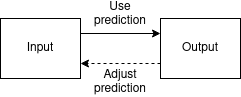 | 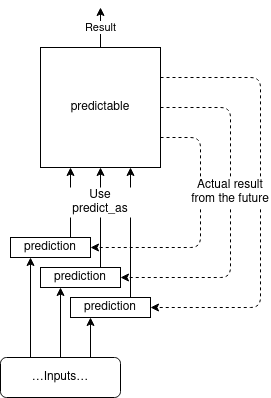

First, the future, in <code>predict<b>able</b>(<code>result_type</code>, <code>predict_as</code><i> = result_type, loss = loss2, channel_from_future = ...</i>)</code>.    
We want to apply the loss function, which takes actual result and ideal result — <code>predict<b>ion</b>(predicted, loss, channel_from_future)</code> and what we compute later. The overall result should be stored in `channel_from_future`, for use by the many predictions during their adjustment.    
Since control-flow of adjustment is exactly the reverse of execution, as long as `predictable` is executed before all same-channel `prediction`s, we'll be fine. We can ensure this by adding `prediction` to the context, generating result, then removing the `prediction`. …Or, even better, just allow predicting what already happened: in an optimizer, if a structure is bad, then it will be superseded by something else.

Bear witness to our code:

     __         __
    /  \.—"""—./  \
    \    -   ‿    /
     |   ○   ○   |
     \  .—'''—.  /
      '-\__Y__/-'
         `———՛

Exploding; restarting…   31298067604e+16.
Exploding; restarting…   48530535224e+16.
Exploding; restarting…   17052947724e+16.
Exploding; restarting…   7933108705e+16.
Exploding; restarting…   6647476524e+16.
Exploding; restarting…   81562215364e+16.
Exploding; restarting…   193000.042..
Exploding; restarting…   43742241804e+16.
Exploding; restarting…   170095.53.8.
Exploding; restarting…   79062662984e+16.
Exploding; restarting…   1927949028e+16.
Exploding; restarting…   18358199908e+16.
Exploding; restarting…   49490302784e+16.
Exploding; restarting…   9851.41214..
Exploding; restarting…   3487384351e+16.
Exploding; restarting…   6440330002e+16.
Exploding; restarting…   376012.365.8.
Exploding; restarting…   08128429324e+16.
Exploding; restarting…   0398751851e+16.
Exploding; restarting…   1900363473e+16.
Exploding; restarting…   73499125384e+16.
Exploding; restarting…   25840.78186.
Exploding; restarting…   89900219464e+16.
Exploding; restarting…   1927949028e+16.
Exploding; restarti

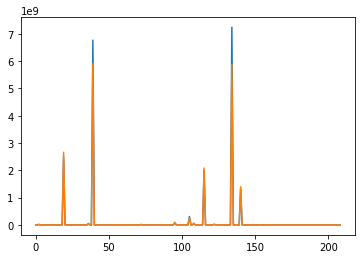

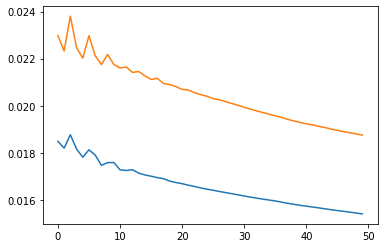

CPU times: user 2min 2s, sys: 5.98 s, total: 2min 8s
Wall time: 2min 3s


In [31]:
class predictable:
    """A type that allows using a value's prediction before the value is computed."""
    def __new__(cls, result_type, predict_as = None, loss = loss2, channel_from_future = None):
        if predict_as is None:
            predict_as = result_type
        return Struct(cls, result_type, predict_as, loss, channel_from_future or [None])

    def typeof(self):
        if len(self) == 4: return self[1]
        else: return Context.typeof(self[1])
    def enum(self): yield self
    def finish(self, _):
        # Nodes that use `Context.type` will be impossible to dynamically re-generate.
        node = Struct(predictable, Context.get(self[1]), self[4])
        Context.type(_prediction_intermed(self[2], self[3], self[4]), self[1])
        return node

    def call(result, channel):
        channel[0] = result
        return result
    def adjust(ins, o, do):
        return do, None

class _prediction_intermed:
    """Type→value intermediate thing, separated from _prediction to remove ambiguity."""
    def __new__(*x): return Struct(*x)

    def call(*x): raise TypeError("Tried to call intermed prediction, with args", *x)

    def filter(enum, cand):
        # Allow remembering same-channel predictions.
        assert isinstance(enum, Struct) and enum[0] is _prediction_intermed
        if isinstance(cand, Struct):
            if cand[0] is _prediction_intermed or cand[0] is _prediction:
                return enum[-1] is cand[-1]
    def enum(self): yield self
    def finish(self, _):
        assert isinstance(self, Struct) and self[0] is _prediction_intermed and len(self) == 4
        x = Context.get(self[1])
        if isinstance(x, Struct) and x[0] is _prediction:
            return x
        return Context.type(_prediction(x, self[2], self[3]), Context.typeof(self))

class _prediction:
    """A function that predicts a `predictable` value then adjusts its prediction."""
    def __new__(*x): return Struct(*x)

    def call(predicted, loss_function, channel):
        return predicted
    def adjust(ins, out, dout):
        # Maybe `predictable` can be viewed as the generation-oriented counterpart to `adjust`.
        predicted, loss_function, channel = ins
        got = channel[0]
        loss = loss_function(predicted, got)
        dloss, _ = adjust(loss_function, (predicted, got), loss, 0)
        return dloss, None, None

# Make sure you understand the above.
#   Look at `call` and `adjust`, ignoring everything else.
#   Then look at what `enum` and `finish` are doing.
#   (`typeof` and `filter` are basically noise.)






# Eventually, we'd like to have a ReNN that locally predicts the global result to pick the best rewriting options.
# But for now, just a routine check that everything works correctly will do.
def test_want(N = 100):
    def weights(*shapes):
        return var(np.random.normal(0, 1, shapes), 0.005)

    channel = [None]

    def nn_pred(it, ot, hidden = 5):
        L = Struct(dense, args(), weights( 2 , hidden))
        L = Struct(leaky_relu, L)
        L = Struct(dense, L, weights(hidden,  1 ))
        L = Struct(access_many, L, 0)
        L = _prediction(L, loss2, channel)
        # We don't bother going through `predictable`'s generation,
        #   because we can't generate NNs yet.
        return AutoFunc(it, ot, body = L)


    def nn_result(it, ot, hidden = 5, channel = None):
        @attr(adjust = lambda i,o,do: (do[:-1], do[-1]))
        def concat(x, c):
            return np.array([*x, c])

        L = Struct(concat, args(), Struct(pred, args())) # Use the prediction.
        L = Struct(dense, L, weights( 3 , hidden))
        L = Struct(leaky_relu, L)
        L = Struct(dense, L, weights(hidden,  1 ))
        L = Struct(access_many, L, 0)
        return AutoFunc(it, ot, body = L)

    @attr(adjust = lambda i,o,do: ((i[0][0] - i[1], None), i[1] - i[0][0]))
    def trickery(m, ideal):
        """Return the prediction's difference, but adjust the result.
        (The prediction must be adjusted indirectly for the reported 'loss' to go down.)"""
        result, p = m
        return (p-ideal)*(p-ideal)/2

    ls, vs = [], []
    def plot():
        plt.plot(ls), plt.plot(vs)
        plt.show()
        ls.clear(), vs.clear()

    import matplotlib.pyplot as plt
    dataset = [(np.array([x/10, y/10]), (x*x + y*y)/100) for x in range(-10, 10) for y in range(-10, 10)]
    random.shuffle(dataset)
    while True:
        pred = nn_pred('2 numbers', 'pred', 5)
        result = nn_result('2 numbers', 'result', 5)
        with Context(pred, result):
            f = AutoFunc('2 numbers', many(predictable('result', 'pred', loss2, channel), pred))

        for i in range(N):
            l, v = fit_dataset_with_validation(f, dataset, loss = trickery)
            sys.stdout.write(f'Epoch {i+1}/{N}, loss {l}.\r')
            sys.stdout.flush()
            if l > 1e10:
                print('Exploding; restarting…   ')
                if i > 10: plot()
                break
            ls.append(l), vs.append(v)
            if i % 50 == 49: plot()
        else:
            break

%time test_want()
# When not exploding, performs the same as `test_nn` but converges slower.
#   Not impressive, but useful for other things.

It's great to be able to say: "This thing already includes the whole of eternity. You just need to show which parts you want."

But now, the past, via <code>stateful(<code>write_type</code>, <code>read_type</code> <i>= write_type, channel_from_past = ...</i>)</code>.

Let's be simple.

The idea is to expose reads to generation (`state_read(channel_from_past = ...)`), and perform writes, on the same reference.

In [32]:
class stateful:
    """A type of references whose value can be written and read."""
    def __new__(cls, write_type, read_type = None, channel_from_past = None):
        if read_type is None:
            read_type = write_type
        return Struct(cls, write_type, read_type, channel_from_past or [None])

    def typeof(self): return self[1]
    def enum(self): yield self
    def finish(self, _):
        Context.type(_read(self[3]), self[2])
        return Struct(_write, Context.get(self[1]), self[3])


class _write:
    """A function that writes the value of a reference."""
    def call(to_write, channel):
        channel[0] = to_write
        return to_write
    def adjust(ins, o, do):
        return do, None
    def typeof(self):
        return Context.typeof(self[1])

class _read:
    """A function that just reads the current value of a reference."""
    def __new__(*x): return Struct(*x)

    def call(channel):
        return channel[0]



# I don't feel right about any of this. Is such recurrence really so fundamental?
#   Would have been nice, killing the mice...

Love your code, and one day, your code will love you too.

In machine learning, features are some multi-dimensional arrays (often just arrays) that are learned, outputted from and inputted into numeric operations. Writing neural networks by hand is getting tiresome, so let's have generatable features, via the <code><b>real</b>(*sizes)</code> type.

Introducing the `dense(output_length)` type.

Normally, the ability to see every possible outcome is provided by in-context composition. But `dense`, being an *everything* itself (as long as we only need static complexity), is somewhat of a special case: it enumerates all pre-existing reals and concatenates them into its input.

(Also, just to show how it might be done, let's add one size-preserving operation on reals: `leaky_relu_op`.)    
(Ideally, we'd like all the numeric operations. But who are we to prescribe the whole of existence? Not someone with enough resources to develop more than art. Ideally, I'd like help with this.)

---

Overriding `Context.enum` like that…    
This just goes to show that every smallest part should become a medium for expression, artistic or random. No static structure.

Random is the first step to artistic. Those unwilling to be random will never be great masters, nya.    
(Though, when not cherry-picked to be funny, and when applied to more consequential things than words, randomness is suffering, beginning with nothing but mistakes. For fundamental things, this obsession is a path rife with shambling zombies walking the ways of the living; the best you can do is establish worst-case limits to not die.)    
Suffering is randomness, randomness is mastery, and mastery is power.

In [33]:
class real:
    """
    A type of fixed-dimensions real-valued tensors that are assumed to not be sensitive to perturbations.
    """
    def __new__(*x):
        for i in range(1, len(x)):
            assert isinstance(x[i], int) and x[i] > 0
        return Struct(*x)
    ops = {}
    def enum(self):
        if isinstance(self, Struct) and self[0] is real:
            if len(self) == 1:
                yield _dense_layer_of_concat(1)
                yield _composed_dense_layer(1)
            if len(self) == 2:
                yield _dense_layer_of_concat(self[1])
                yield _composed_dense_layer(self[1])
            for o in real.ops.values():
                yield Context.type(o, self)
    def filter(enum, cand):
        """All sizes must be equal."""
        if enum is real: return True
        assert isinstance(enum, Struct)
        t = Context.typeof(cand)
        if t is real: return True
        if not isinstance(t, Struct) or len(enum) != len(t): return
        for i in range(1, len(t)):
            if enum[i] != t[i]: return
        return True



# It all used to be so small and beautiful, but then machine learning happened.
#   I don't think any of this is the eternal elegance.
#   And I'm pretty sure I'm doing something somewhere wrong, because nothing is learning well.

class _dense_layer_of_concat:
    """
    Type of a function that linearly connect every input to every output.
    Input positions are the only things that matter.
    """
    def __new__(cls, result_len):
        assert isinstance(result_len, int)
        return Struct(cls, result_len)
    def typeof(self):
        return real(self[1])
    def enum(self):
        yield from Context.enum(real(self[1]))
    def finish(self, Type):
        """Enumerates all pre-existing reals and concatenates them into its input."""
        assert isinstance(self, Struct)
        ins, total_ins_size = [], 0
        for med in Context.enum(real):
            T = Context.typeof(med)
            if not isinstance(T, Struct) or T[0] is not real: continue
            total_size = _prod(T, 1)
            if total_size < 1000:
                # Heuristics, all over ML. You'll realize you're one of them, sooner or later.
                ins.append(med)
                total_ins_size += total_size
                if total_ins_size > 2000:
                    break
        ins = random.sample(ins, -(-len(ins) // random.randint(1, 4)))
        assert len(ins), "Too few potential real inputs"
        ins = [Context.finish(v, Type) for v in ins]
        total_ins_size = sum(_prod(Context.typeof(med), 1) for med in ins)
        if len(ins) > 1:
            op = Struct(_flat_concat, [Context.typeof(x)[1:] for x in ins], *ins)
        else:
            op = ins[0]
        op = Struct(_dense_func, op, var(np.random.normal(0, 1, (total_ins_size, self[1])), .01 / total_ins_size))
        # This matrix creation method, and its adjustment, could be different.
        return op

class _composed_dense_layer:
    """Intermediate class that generates _dense_func with a real(…) as an input."""
    def __new__(cls, result_len): return Struct(cls, result_len)
    def finish(self, _):
        hidden_size = random.randint(5, 10) # Very fiddlable.
        x = Context.get(real(hidden_size))
        var_size = hidden_size * self[1]
        return Struct(_dense_func, x, var(np.random.normal(0, 1, (hidden_size, self[1])), .01 / var_size))

class leaky_relu_op:
    """
    An operation that introduces discontinuity.
    np.where(v > 0, v, v * .001)
    """
    def finish(self, _):
        if self is not leaky_relu_op: return self
        # Get an instance of the size passed in by `real`'s `enum`:
        return Struct(leaky_relu_op, Context.get(Context.typeof(self)))
    def typeof(self):
        return Context.typeof(self[1])
    def call(v):
        return np.where(v > 0, v, v * .001)
    def adjust(i,o,do):
        return (np.where(i[0] > 0, do, do * .001),)

real.ops['leaky_relu'] = leaky_relu_op




def _prod(arr, start = 0):
    """Returns the product of items in an iterable."""
    p = 1
    for v in arr:
        if not start: p *= v
        else: start -= 1
    return p

class _flat_concat:
    """Concatenates numpy arrays into one flat array, or splits the change properly."""
    def call(sizes, *t):
        assert len(sizes) == len(t)
        return np.concatenate(
            # Passing in axis=None instead would not handle None inputs.
            [t[i].flatten() if t[i] is not None
            else np.zeros(sizes[i])
            for i in range(len(t))])
    def adjust(ins, out, dout):
        sizes, *tensors = ins

        cs = np.cumsum([_prod(sz) for sz in sizes])[:-1]
        return [None] + [r.reshape(sizes[i]) for i, r in enumerate(np.split(dout, cs))]

    def typeof(self):
        """A vector of length sum-of-mult-of-input-sizes."""
        return real(sum(_prod(sz) for sz in self[1]))

class _dense_func:
    """Linearly connects every position to every position.

    The second argument is a random matrix of .shape = (input_size, output_size)."""
    def call(x, w):
        """np.matmul of a vector by a matrix."""
        if x is None:
            x = np.zeros(w.shape[0]); x[0] = 1.
        return np.matmul(x, w)
    def adjust(ins, out, dout):
        """https://github.com/tensorflow/tensorflow/blob/v2.2.0/tensorflow/python/ops/math_grad.py#L1668"""
        x,w = ins
        if x is None:
            x = np.zeros(w.shape[0]); x[0] = 1.
        if dout is None:
            dout = np.zeros(w.shape[1])
        dx = np.matmul(dout, np.transpose(w))
        dw = np.matmul(np.reshape(x, (w.shape[0], 1)), np.reshape(dout, (1, w.shape[1])))
        return dx, dw

    def typeof(self):
        v = self[2]
        if isinstance(v, Struct):
            v = v[1] # Handle var(NumPyArray, …).
        return real(v.shape[1])

Best loss: 0.01861036903428271.36903428271; current loss: 43.89382848918116.2.16.


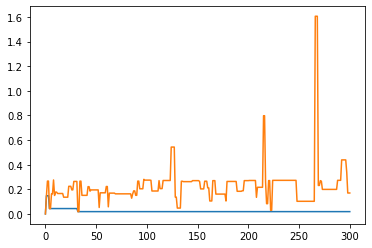

Mutation probability: 0.0003333333333333334 → 0.000582814418819278.
CPU times: user 14min 36s, sys: 11.6 s, total: 14min 48s
Wall time: 14min 41s


In [34]:
# The test is separated, for us to be able to change source without re-running this.

def _clear_body(node, ae, am):
    """(graph_node, ascent_estimate, ascent_message) -> (node_becomes, ascent_estimate)"""
    if isinstance(node, Struct) and node[0] is instance:
        node = Struct(*node)
        node[2] = ...
    return node, None

def test_dense_layer(N = 300):
    def static_learning(f, dataset, loss):
        """Return the minimal validation loss of this individual change, after training for 30 epochs."""
        try:
            with Limit(Limit.time(), 20):
                ls = []
                for _ in range(30):
                    ls.append(fit_dataset_with_validation(f, dataset, loss)[1][0])
                    if ls[-1] > 1e5: break
                return min([float('inf')] + ls[5:])
        except KeyboardInterrupt:
            raise
        except _LimitExceeded:
            return float('inf')

    dataset = [(np.array([x/10, y/10]), (x*x + y*y)/100) for x in range(-10, 10) for y in range(-10, 10)]
    random.shuffle(dataset)
    initial_prob = .1 / N
    prob_holder = [initial_prob]
    f = AutoFunc(real(2), real(), regenerate_when = prob(_read(prob_holder)))
    best = None
    with Past() as p:
        bs, cs, probs = [0], [0], []
        for i in range(N):
            # Try to fine-tune the regeneration probability.
            #   (With non-trivial datasets unlike here, should go toward 0, all jittery, licking limits.)
            #   (The body is implicitly fine-tuned too, as long as it doesn't regenerate too much.)
            Past.save(prob_holder);  prob_holder[0] *= random.uniform(0.5, 2)
            regenerate(f, None, _clear_body) # The fanout is FAR too great, even with this.
            regenerate(f)

            current = static_learning(f, dataset, loss2)
            if best is None or current < best:
                p.update()
                best = current
            else:
                p.go_back()
            probs.append(prob_holder[0])
            bs.append(best if best < 10 else bs[-1]), cs.append(current if current < 10 else cs[-1])

            # Had a memory issue. Added a GC collection.
            #   Made `Past` use weak references.
            #   No, there is still a memory leak somewhere.
            #   Even though there are only about 100 objects after this, no gc.garbage.
            #   Removed weak refs from `Past`, because new objects call `Past.new` anyway.
            import gc
            gc.collect()

            sys.stdout.write(f'Meta-epoch {i+1}/{N}. Best loss: {best}; current loss: {current}.\r')
            sys.stdout.flush()
        log(f'Best loss: {best}.')
        plt.plot(bs)
        plt.plot(cs)
        plt.show()
        log(f'Mutation probability: {initial_prob} → {prob_holder[0]}.')

%time test_dense_layer()

Once again, the problem it's used on is too simple. But at least it technically works, sometimes.

Do you know yourself, your preferences, tendencies, your strengths and weaknesses?    
I often think I do, but my information always turns out at least a few months out of date.    
Do you know knowing? A learned thing, no? Even fundamental things are actually learned.

I would like to be able to learn completely arbitrary functions and their adjustments. Technically, we've already covered functions (but the output should be typed `...`), but generating adjustment (and optimizing how fast the result learns) is not well-understood.

First, the interface: `class BasicFunc` that is just like `AutoFunc`, but has an extra exposed switch for when-to-change-adjustment.

Let's say that we have a function typed `In → Out`. What is its adjustment (semantically `in,out,dout → din`) typed as? If change of type is the same as type, then the adjustment is typed `(many In Out Out) → In` (well, `adjust` passes 3 arguments and not 1 tuple, so we'll need a thin extra layer: `_SingleFunc`).    
Assuming here that generation is equally possible in both directions, and that every type implicitly includes `None`.

Alright, generation is simple enough. But what's a good optimizer for what is generated here?    
Clearly, adjustment is used for static-structure learning, so we need to measure that.    
Static learning: repeat `fit_dataset` *some* count of times (100?), then return *some* measure of fitness (the final loss, or the average loss, or some other numbers→number function I can't prescribe; all divided by time taken, to measure speed).    
This is used in dynamic learning: remember the past, do a random change, get fitness, go back if didn't improve, update if improved. (Local search, as described in `help(Past)`.)

Your keen eye instantly thinks that those *some*s above exist to be learned, to be inlined and fiddled with in some greater context to get more performance on some tasks. That's true, but we won't do that now. Still, good job catching that.

Also, it should be said that the result of static learning will always be random in some sense, so there's no guarantee that dynamic learning will improve an objective interpretation of what it optimizes, and it could easily be thrown off by outliers. Ideally, it should sometimes re-calculate best fitness, to average errors out; we don't do that here.

In [35]:
[np.random.normal(0, 1, [])][0]

array(0.70124311)

<ipython-input-36-6e388d9293d0>:156: RuntimeWarning: overflow encountered in multiply
  L = (result - ideal) * (result - ideal) / 2
<ipython-input-33-b89d60bb07be>:140: RuntimeWarning: overflow encountered in matmul
  return np.matmul(x, w)
<ipython-input-33-b89d60bb07be>:140: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(x, w)
<ipython-input-33-b89d60bb07be>:96: RuntimeWarning: invalid value encountered in greater
  return np.where(v > 0, v, v * .001)


<ipython-input-36-6e388d9293d0>:99: RuntimeWarning: invalid value encountered in true_divide
  return (ls[-1] / ls[1]) * dur, ls[-1]


<ipython-input-13-9506d3cf96de>:102: RuntimeWarning: overflow encountered in add
  return sum(test_losses) / len(test_losses), sum(validation_losses) / len(validation_losses)


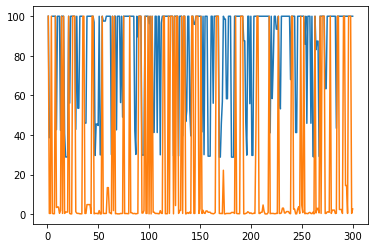


v0 = [array(0.69245627)]
v1 = False
v2 = [array(0.75248131)]
v3 = args()
Best's call: instance(<__main__._wrap object at 0x7fe5798c2400> leaky_relu_op(_read(v0)) v1) 
  Best's adjustment: instance(<__main__._wrap object at 0x7fe5798c27c0> _last_func(_write(_read(v2) v2) _write(access_many(v3 1) v0) access_many(v3 0)) v1)
CPU times: user 4min 36s, sys: 14.6 s, total: 4min 51s
Wall time: 4min 30s


In [36]:
def concrete(T):
    """Returns a random concrete value of a type."""
    # We don't handle type graphs/DAGs for simplicity.
    if isinstance(T, Struct):
        if T[0] is real: return np.random.normal(0, 1, T[1:])
        if T[0] is last: return concrete(T[-1])
        return Struct(T[0], *(concrete(ch) for ch in T[1:]))
    return T



class BasicFunc:
    """
    A function with mutable execution and adjustment.
    Like `AutoFunc`, but adjustment is learned too.

    `ins_t`: the type of input.
    `out_t`: the type of output.
    `state_t`: list of types of mutable states that execution reads and adjustment adjusts. `concrete` will be used to generate these.
    `ctx`: context of everything available to generate function bodies.
    `regen_call` and `regen_adjust`: function body parts that return True when it's time to regenerate.
    """
    __slots__ = '_call', '_adjust', '_compose_signature', '_channels', '_channel_types'
    def __init__(self, ins_t, out_t, state_t = [], ctx = None, regen_call = False, regen_adjust = False):
        if ctx is None:
            ctx = Context._current()
        self._channels = [Past.new([None]) for _ in state_t]
        self._compose_signature = ins_t, out_t
        self._channel_types = state_t
        self._regen_channels()

        # And add state read/write to contexts, and set the functions (making sure that `adjust` writes):
        call_ctx = Context(ctx)
        with call_ctx:
            for i, ch in enumerate(self._channels):
                Context.type(_read(ch), state_t[i])
        self._call = AutoFunc(ins_t, out_t, call_ctx, regen_call)

        adjust_ctx = Context(ctx)
        with adjust_ctx:
            dins_t = Struct(last, *([None] * len(state_t)), ins_t)
            for i, ch in enumerate(self._channels):
                write = stateful(state_t[i], state_t[i], ch)
                Context.add(write)
                dins_t[i+1] = write
            if len(dins_t) == 2: dins_t = dins_t[-1]
        self._adjust = AutoFunc(many(ins_t, out_t, out_t), dins_t, adjust_ctx, regen_adjust)

    def __call__(self, ins):
        out = self._call(ins)
        with GetExecState(self._call): pass
        return out

    def adjust(self, ins, out, dout):
        # I'm worried that all that tuple packing/unpacking is not JITed away.
        dins = self._adjust((ins[0], out, dout))
        with GetExecState(self._adjust): pass
        return dins

    def regenerate(self, up, down):
        self._regen_channels()
        regenerate(self._call, up, down)
        regenerate(self._adjust, up, down)

    def _regen_channels(self):
        """Regenerates values stored in state channels here, using `concrete`."""
        ch, ch_t = self._channels, self._channel_types
        for i in range(len(ch)):
            Past.save(ch[i])
            ch[i][0] = concrete(ch_t[i])

    # Types, defined by such precise functions.
    #   Eventually, we'd like to learn them too.
    #   Everything that is created must eventually be subverted.
    def typeof(self):
        """Returns the type of output (function body)."""
        if isinstance(self, Struct): return self
        return self._compose_signature[1]




# Just a test of the above below.
def test_opt_opt(N = 300):
    def static_learning(f, dataset, loss, N = 30):
        """Return anti-fitness (meta-loss) of this individual change, the less the better."""
        t = Limit.time()
        with Limit(t, 30):
            ls = []
            for i in range(N):
                ls.append(+fit_dataset_with_validation(f, dataset, loss)[1])
                if np.isnan(ls[-1]): break
                if i == 5 and ls[-1] >= ls[0]: break
                if i == 10 and ls[-1] >= ls[5]: break
                if i == 15 and ls[-1] >= ls[10]: break
                # Could also, from losses-so-far, predict the final result, and if it's too low, abort early.
        if len(ls) < 5 or np.isnan(ls[-1]): raise _LimitExceeded('kinda')
        dur = max(t() * (1 + 10 * (N - len(ls))), 1)
        return (ls[-1] / ls[1]) * dur, ls[-1]
        # Could also try other measures of losses (like ls[-1], or sum(ls)/len(ls)).

    def pp(s):
        sys.stdout.write(s)
        sys.stdout.flush()
    def argmin(a, start = 0):
        mi = start
        for i in range(start+1, len(a)):
            if a[mi] is None or a[i] is not None and a[i] < a[mi]:
                mi = i
        return mi

    def dynamic_learning(f, dataset, loss, N):
        """Performs change, preserves the best. Returns the array of meta-losses."""
        with Past() as p:
            best = None
            mls, fls = [None], [None]
            # Could be more sophisticated: more pasts, different criterias, rewriting that learns.
            try:
                for i in range(N):
                    try:
                        regenerate(f)
                        regenerate(f)
                        regenerate(f)
                        notfit, final_loss = static_learning(f, dataset, loss)
                        if best is None or final_loss+.1 < best:
                            p.update(); best = final_loss+.1
                        elif best < final_loss+.1:
                            p.go_back()
                    except _LimitExceeded:
                        p.go_back(); notfit = final_loss = None
                    mls.append(min(notfit if notfit is not None else mls[-1] or 100, 100))
                    fls.append(min(final_loss if final_loss is not None else fls[-1] or 100, 100))
                    m1, m2 = argmin(mls, 1), argmin(fls, 1)
                    pp(f'{i+1}. Best by meta-loss here: {mls[m1], fls[m1]}, best by final loss here: {mls[m2], fls[m2]}.   \r')
                    if i % 300 == 299:
                        plt.plot(mls), plt.plot(fls)
                        plt.show()
                        mls.clear(), fls.clear()
                        mls.append(None), fls.append(None)
                p.go_back()
                log('')
                log('Best\'s call:', f._call._struct, '\n  Best\'s adjustment:', f._adjust._struct)
                return mls
            except KeyboardInterrupt:
                p.go_back()
                log('')
                log('Best\'s call:', f._call._struct, '\n  Best\'s adjustment:', f._adjust._struct)
                raise

    channel_from_future = [None]
    @attr(adjust = lambda i,o,do: (i[0] - i[1], i[1] - i[0]))
    def predictable_loss(predicted, got):
        """Exactly like `loss2`, but the loss can be predicted locally before it's available.
        (Is there a good way to make this less bootleg, I wonder.)
        (Making the type of dataset's output predictable, maybe?)"""
        L = (predicted - got) * (predicted - got) / 2
        channel_from_future[0] = L
        return L

    dataset = [(np.array([x/10, y/10]), (x*x + y*y)/100) for x in range(-10, 10) for y in range(-10, 10)]
    random.shuffle(dataset)
    with Context(_prediction()): # Could also have extra BasicFuncs and AutoFuncs in the context.
        Context.type(_prediction_intermed(real(), loss2, channel_from_future), real())
        f = BasicFunc(real(2), real(), 2*[real()])

    dynamic_learning(f, dataset, predictable_loss, N)

%time test_opt_opt()
# Issue log:
#   Predictions can double-predict: _prediction(_prediction(…), …).
#     ✅ Added a check to _prediction_intermed.
#   Size mismatches in `_dense_func`?
#     ✅ `Context.finish` may change predicted sizes; moved the final size-sum to after that.
#   Tuples are being passed to `_flat_concat` and sometimes to `_leaky_relu_op`.
#     ✅ Now passing in `ins[0]` as `ins` to `BasicFunc(…).adjust`.
#   AutoFuncs seem to be not found for adjustment in `GetExecState`; outer node is None.
#     ✅ See where the AssertionError is swallowed.
#       …Oh, adding a print statement before throwing makes the throw actually happen.
#       Removing it is ok too.
#       Thanks, Python.
#     ✅ …Not supposed to adjust adjustment, supposed to call adjustment. Fixed.
#       While I was at it, I also removed the unnecessary adjustment state.
#   There is no state to adjust. We literally can't learn anything.
#     And now you learn to trust my initial word-based "future & past" analysis.
#     ✅ Pass in `state = 5*[type]` to `BasicFunc(…)`,
#       ✅ and make AutoFunc(ctx=…) not copy ctx but take it as-is for efficiency,
#       ✅ and have '_channels' and '_channel_types' on BasicFunc,
#       ✅ and create two contexts for funcs and do `Context.type(_read(ch), r)` with them,
#       ✅ and re/generate current values of state (`ch[0] = self._state_types[…]`) with `concrete(type)`,
#       ✅ and make adjustment's out type `last(stateful(type, type, ch), …, T)`, to make it write.
#   ✅ Re-check it for a big count of meta-epochs.
#     After 1000 meta-epochs, best final loss is about 0.06 (4x of test_nn).
#       Impressive, considering that I forgot to give it any state to adjust.
#   `stateful` confuses it-as-type and it-as-function.
#     ✅ Separate `stateful` into type and function.
#   No writing happens.
#     ✅ Use `dins_t` instead of `ins_t` for generating adjustment's output.
#   (Many-_reads-of-the-same-channel and _write-of-_write are generated, but I don't care.)
#   ✅ Run it for 3000 epochs. (…50 is often enough.)
# I love encountering bugs. They won't hurt anyone ever again.

About `0.089` best final loss (compared to `0.015` of `test_nn`) after 50 meta-epochs, by just reading a number. About what should be expected from having randomly-initialized unchangeable dense layers and reading/writing.    
The proper way to subvert things would be to pair generators with predictors, so that each choice can be made to maximize the result, then *gradually* adding a learned representation to a thing. Just random generation is essentially trash, compared to that. Later, perhaps?

Let us pray to our God, the infinite everything.    
Let It deliver to us ever improving assumptions.    
O unyielding light, may our generators be complete.

This section ballooned like a pufferfish. It yearns to be over.

Did you hear about the [Wolfram Physics Project](https://writings.stephenwolfram.com/2020/04/the-wolfram-physics-project-the-first-two-weeks/)? I won't [explain it](https://www.wolframphysics.org/technical-introduction/introduction/), but from "let's assume that the universe is nothing but some graph and computation on it: all ways to apply rewriting rules exist, and all rules exist" it derives essentially all physics (well, it's in early-ish stages, so technically it's impossible to tell).    
Obviously, a limited *something* (like `lambda x: x*2`) is not the universe, and this model relies heavily on being an *everything*, which means that everything is eventually derivable from everything (is *causally invariant*: the particular cause doesn't matter; alternatively, has sufficient effective randomness).    
It's neat: with it, a fully general learning system (intelligence, which is an *everything* that can and has become absolutely anything it wants/needs) does not just *metaphorically* create its own little universe, but also literally.

Maybe I should explain what I meant by nothing/something/everything.

Here is a *nothing*:

In [37]:
# More potential than a baby

Here is a *something*:

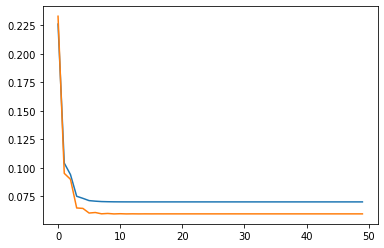

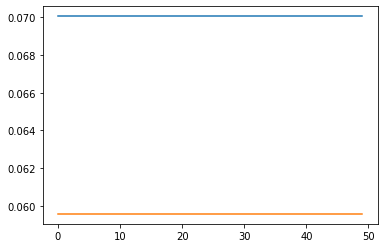

In [38]:
test_nn()

Here is an *everything*:

```python
state = None
while True:
    import random
    import string
    random_string = ''.join(chr(random.randrange(32, 256)) for _ in range(100))
    try: state = eval(random_string, globals())(state)
    except: continue
# Not practically useful ever, but theoretically capable of anything.
#   Good enough for illustration.
```

With a concrete formulation like this, it's obvious that every thing cannot be contained in *nothing*, but it can be contained in *everything*.

Keeping in mind that "a software system" or "a formal set of rules" are *something*s, it can be said that *nothing* only exists as a shadow that a *something* casts onto *everything* (the universe, which is not a *something* and has no fundamental *nothing*).

Some hurry to expound how wrong everyone around is, and how meaningless their lives are.    
Others say that intelligence is not good enough for all endeavors, so you need to dare to be stupid.    
Others say that you need to let go of all worldly attachments like friends or machine learning frameworks.    
Those are worshippers of the *nothing*. A solid first step, but there are things beyond all that: the *everything*.

Dealing with the infinity of everything is understandably difficult, and can give rise to persistent misconceptions, including but not limited to:
- Humans have no one goal when averaged, so, their life has no meaning. In fact, it has every meaning, transforming into each other in some human-ly ways. Death is not rebirth; philosophers are people that can't separate the two. (*nothing* ≠ *everything*)
- Life has no unifying structure that defines it, therefore, there's nothing more "alive" about humans than about a sand beach. But a self-subversive generative process is markedly and obviously different from a non-generative one. (*something* ≠ *everything*)
- Any life is as good as any other, so there is no need to fully understand all details of someone else if you can just understand them as a different yourself. Understanding AI like that is like trying to become a legendary general by reading enough general self-insert fanfics. (*everything* ≠ *everything*)
- Humans can do anything and become anything they want. Efficient *everything*s are definitely embedded, however, as anyone who's ever *not* been a creative super-genius for their whole life can attest, static human instincts define most of their existence, and are hard to subvert: much to improve upon. Don't prescribe the best of humanity to all of humanity, nor the other way around. (*something* + *everything* ≠ *everything*)

Try to avoid these.

## Choice

To surprise, to delight… Is that right? It's nice to not fight, to listen to a gentle light. Glad you could join us, even if only for a fleeting moment.

There is always a choice: life or death, cookie or ash, read or play, constructive or criticism.    
The best we can do is try to see what each choice means, to know what's the best one.    
To get so far, your choices must have made you something special.    
But don't forget to take a nice relaxing break.

We'd like our <code><b>one</b>(*options)</code> type to mean a choice of types.    
There was `match_id` in the previous section, so we have some experience with pattern-matching.

Crafty hacker, do you prefer the hollowness of a specific definition, warts and bugs and all… or the richness of what it's supposed to be?    
`one(…)` represents a union type. These are an essential part of representing all data types in an elegant language: say, <code>Tree<b>(</b>a<b>)</b> = <b>one(</b>null, Ent<b>(</b>a, Tree<b>(</b>a<b>)</b>, Tree<b>(</b>a<b>)))</b></code> specifies a tree: either nothing, or a node with data typed `a` and two tree children. (Or, if we don't have to worry about doing the same work twice (for example, pure function results are cached, and generation can remember same-type values), then this is a DAG (directed acyclic graph) type.)    
Many pretty languages have been build on this paradigm. But what about a generative lens of view?
- A function that returns such a `Tree` can pick any branch and likely recurse on itself to create an arbitrary DAG. It can potentially learn to extract a good structure from non-structural input. (For this, `AutoFunc` ought to add itself to its context, and generation should filter away the boring `f(x) = f(x)` trivial-infinite-loop cases. Execution should be resilient to non-trivial infinite loops, but `Limit` does that already.)
- A function that takes such a DAG pattern-matches each case in any way. If it also takes and returns the same type (probably a `real` named `ascent_estimate`) with a merging operation, then that's half of `rewrite` right there (`ae = ascent(node, ae_sum)`). (Proper descent, which requires descending into a child only after all its parents gave it estimates, doesn't seem plausible in pure function call regime, and needs tricky-to-generate dict wizardry. …Maybe we could translate `one` inputs into `rewrite`s? How, though?)
- A function that takes and returns such a DAG (and a soft `real`) is an arbitrary rewrite rule, optimizable to return the best-performing DAG and its performance.
- Functions from and to a generative type of all types, in particular product and union and singleton types, would contain all lists, all DAGs, all execution models, all programs, all behavior, all meaning, all awareness. (This one should probably wait until after we can easily specify more fiddlable choices than `random.randint(0,9) == 0`.)

Pretty, but an optimization nightmare compared to `rewrite`.    
(But maybe, eventually, it's better to switch to that, to allow different flow, such as "try several times and pick the best"? It needs really advanced optimization techniques that I haven't seen, possibly even including proofs. What's better: painstakingly specifying a dependent-type structure, or learning something that behaves like it?)

---

But first, need more experience on the boring old ground zero.    
…I mean, sublimely fascinating code.

In composition, I've been composing output from inputs.    
But just one direction isn't enough: if an input's result is uncertain, generation of output must happen only after the uncertainty has been pattern-matched away.    
The `renn` example already had a function that dispatches based on object id (named `matcher`). We'd like to have that here too, in `match_id(generate_as)`.

When it is `finish`ed generating, it should bail out to the top-level (by raising an exception, `_GenerationResult`).    
The top level (`regenerate`) should become a function that does what `matcher` in `renn` does: pattern-match by id.    
When a particular implementation is requested to be created by the matcher, the `match_id` has to become some other type (its parameter).

In [39]:
class match_id:
    def __new__(cls, gen_as = None): return Struct(cls, gen_as)
    def call(arg, branches, obj, missing):
        return match_id._in_branches(branches, obj, missing)(arg)
    def adjust(ins, o, do):
        return adjust(match_id._in_branches(ins[1], ins[2], ins[3]), (ins[0],), o, do)
    def _in_branches(branches, obj, missing_generator):
        # Dicts of id(obj), all over the code. They'll trip over equal ids, sooner or later.
        Id = id(obj)
        if Id not in branches:
            branches[Id] = missing_generator()
        return branches[Id]

    def enum(self):
        assert False, "match_id(…) objects cannot be generated"
    def add(v):
        """Pattern-match when added."""
        t = Context.typeof(v)
        assert isinstance(t, Struct) and t[0] is match_id
        Context.type(v, t[1])
        node = Struct(match_id, args(), {}, v, ...)
        raise _GenerationResult(node, t, t[1])





def test_match_id():
    f = AutoFunc(match_id('a'), 'a')
    log(f(5), '= 5')

    g = AutoFunc(many(match_id('a'), 'a'), 'a', regenerate_when = prob(.2))
    s = set(g([i % 10, -7]) for i in range(500))
    log(s)
    assert -7 in s
    assert len(s) == 11

%time test_match_id()

5 = 5
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -7}
CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 162 ms


The old architecture didn't lend itself well to matching, and we had to add machinery to specifically support this.    
And it's so hacky.

Well then, how would we actually implement `one`?    
Let's start with something simple: fully generate each option, then pick a random one.

In [40]:
class one:
    """Type of one of many."""
    def __new__(*x): return Struct(*x)

    def enum(self):
        """Enum each item."""
        for i in range(1, len(self)):
            yield from Context.enum(self[i])

    def add(v):
        """Pattern-match when added."""
        ## `match_id`'s method of raising an exception and giving it an _AFCopier afterwards
        ##   won't specify the pattern-matched type in each branch. Enough hacks.
        raise NotImplementedError()

    def finish(self, _):
        """Pick a random one."""
        return Context.type(Struct(random.choice, *self[1:]), self)

All such garbage. What we want are general principles of hierarchical choice optimization; who cares about nice symmetrical types? There are serious systemic issues in my approaches prior to this.    
Setting sights on *something* infinitely beautiful and far away, only to never get a reality check because it's so tricky to implement… It makes me sick.    
Like those people that think self-awareness is intelligence's most elusive property, and having it implies AGI. They never thought of what code it corresponds to. Look at this:

In [45]:
help(help)

Help on _Helper in module _sitebuiltins object:

class _Helper(builtins.object)
 |  Define the builtin 'help'.
 |  
 |  This is a wrapper around pydoc.help that provides a helpful message
 |  when 'help' is typed at the Python interactive prompt.
 |  
 |  Calling help() at the Python prompt starts an interactive help session.
 |  Calling help(thing) prints help for the python object 'thing'.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, *args, **kwds)
 |      Call self as a function.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [77]:
s = "s = SELF\nprint('I am a console application, implemented as:\\n')\nprint(s.replace('SELF', repr(s), 1))"
print('I am a console application, implemented as:\n')
print(s.replace('SELF', repr(s), 1))

I am a console application, implemented as:

s = "s = SELF\nprint('I am a console application, implemented as:\\n')\nprint(s.replace('SELF', repr(s), 1))"
print('I am a console application, implemented as:\n')
print(s.replace('SELF', repr(s), 1))


Python is self-aware. A console application that prints "I am a console application" and quines its code (like my language can) is even more self-aware. Clearly, we're about to be taken over.

Let's remember what we want: repeatedly change a DAG structure in some way, and evaluate each structure, to find the best. The 'change' are rewriting rules, 'evaluate' is train for 100 epochs or something like it, but this is the overall gist.

We have state, transitions on it, and we want to maximize a final value. You know what this reminds me of? MuZero.

MuZero is an algorithm for playing games. The 'game' here means "given state (of a Go board, etc) and action (where to place the stone), give new state and reward (whether lost/won/playing)", where we want to maximize the cumulative (or final) reward (after transitioning between states).    
That algorithm does that by learning the virtualization of state into a numeric representation, learning state transition, and learning search results. Very neat: everything virtualized.

On the surface level, it's very similar to what happens in local search, so maybe it could be used there. But details are… complicated.

To formalize what we want a little bit: we have some data structure (code), the ability to run it (giving us whether a program compiles and its fitness) and to change it (which can modify any part).    
(This is a tad more exciting than playing games: what if our code representation is Turing-complete, and the system can learn to write better versions of itself?)

Immediately, there is a problem: there isn't a finite set of actions that we can do. So let's look at what we actually have.

1. We have a DAG given by recursive arrays, and we descend into it then ascend, and when we ascend, we can choose to either keep the node the same or make it into any one of `Context.enum(Context.typeof(node))`, which can create a new instance or choose an old DAG. (Note that now, we shouldn't ever call `Context.get` ourselves, but instead return `finish(type)` in the graph, to give the parent control over the choice.)    
So we have a finite choice. But it's a local choice, whereas the search happens on global results.    
There is only one possibility here: to predict the global policy/fitness locally.    
Locally, we have numeric ascent/descent estimates and message from descent to ascent, but we also must condition on the option.
2. There are several kinds of options we'll see: a DAG structure, and an object with a unique ID (such as a type that generates structure). A recursive NN should handle structure, and a separate numeric variable should be created for each unique object.    
A lot of these structures are mostly shared, so we need to cache them. We'll need a recursive NN that only ascends, as it does not depend on the entry point.    
We should have a function that produces a function that can be called on an option: `option_handler(feature_size)(option)`. Also, `rewrite` should call `ascend` on non-structs, for uniformity and to store more state.
3. Built-in functions are black-box, and can be pattern-matched by object ID to have their own NNs. But what about white-box sub-functions?    
We could treat these as black-boxes too, learning the role for each function separately, but this won't be able to predict post-change things.    
We need to recurse into bodies of these little devils. Which means that we need to rebrand `ascend` into "given descent estimate, give ascent estimate".    
Function bodies are acyclic, but for arbitrary recursion, functions themselves can be cyclic. We can either take inspiration from graph NNs and do several iterations of message-passing on the function graph (can't easily imagine how to *not* upend all control flow with this), or for cyclic references, have 1 or more sub-estimators that predict the final ascent estimate, or just make currently-being-handled references pass their message through.    
Now, I know that people are supposed to spend tens of thousands of hours on things that don't pan out, but I *think* I'm attracted to the last option.

With all that, we *should* be able to predict global estimates locally and search for the best option. With a good enough model, we could do many rewrites without evaluating, to arrive to the best option and just evaluate that once.    
It may be slow to do a search 1000 times per rewrite, but, you know, **compute**. Pretty sure that it can learn to be *much* better than things like evolution, especially if trained on a Turing-complete function set, and every program and goal are specified using those. I don't see any better way to do arbitrary white-box optimization that is necessary for general AI; do you?

If it bleeds, we can kill it. So, I'll recap what I'll do, and you can follow along if you like:

✅ `rewrite` should call `ascend` on non-structs. For this, just put non-structs into `_postorder` and push the struct check onto its users.    
✅ Everything that uses `rewrite` (from Ctrl+F, `regen_t` in `test_rs_1`, and `matcher` in `renn`, and `regenerate`'s `_regen_node` and `_clear_body`) should handle non-structs properly too.    
✅ Re-run and test everything.

Behind this format lies an effective task executioner. Nurture.

✅ Ctrl+F `Context.get` to gauge the plausibility of inverting control over replacing.    
The only odd cases are `access_many` and `_dense_layer_of_concat` (which uses `Context.finish` to pick every enumeration at once); probably good to leave as-is.    
⬛ Have a class `of_type(Type)` as a replacement for `Context.get` for structs returned from `.finish`, rewrite that in `Context.finish` into instances of the type, and change all `Context.get` to this.    
A way to rewrite that is to have `depth=1` parameter to this `finish`, make users remember to pass in the proper value in uncommon situations, and have a global variable in `Context.finish` for max depth.    
Another way to rewrite that is to maintain a set of node id in `rewrite` (or any other user of `Context.get`/`Context.finish`), and check that constantly (and set it in a global var). Dict/set stores are less efficient than just postorder, but this is a much more general/convenient way to not go into already-seen things.    
✅ Have `with of_type.Seen():` (used in `rewrite` and all `.has`-needing places) and `of_type.add(x)` and `of_type.has(x)` for the above.

In [ ]:
class of_type:
    """`of_type(T)` indicates that the host should replace it with `Context.get(T)`.

    This inverts control, allowing custom picking from enumerated options."""

    def __init__(self, T):
        self.T = T
    __slots__ = 'T',

    _current = None

    @staticmethod
    def has(x):
        if of_type._current is not None:
            return id(x) in of_type._current
    @staticmethod
    def get(x):
        if of_type._current is not None:
            return of_type._current[id(x)]
    @staticmethod
    def set(x, to):
        if of_type._current is not None:
            of_type._current[x] = to

    class Seen:
        """Context manager in which the same node won't be visited twice (if checking `of_type.has(node)`)."""
        current = None
        __slots__ = 's', 'prev'
        def __init__(self):
            self.s, self.prev = {}, None
        def __enter__(self):
            assert self.prev is None
            self.prev, _of_type_Seen.current = _of_type_Seen.current, self.s
        def __exit__(self, x,y,z):
            assert _of_type_Seen.current is self.s
            _of_type_Seen.current, self.prev = prev, None



def _get_types(x):
    """Rewrites `of_type(T)` into a `Context.get(T)` in the Struct-based acyclic graph `x`."""
    if x is of_type:
        ## This doesn't actually change the method of picking…
        return Context.get(x.T)
    if not isinstance(x, Struct): return x

    # Graph-walk header.
    copy = Struct(*x)
    if of_type.has(x): return of_type.get(x)
    else: of_type.set(x, copy)

    # Graph-walk.
    for i in range(1, len(x)):
        copy[i] = _get_types(x[i])
    return copy

## Also set `Context.finish` to a new function that uses `_get_types`.

Oh dear. Not only does it impose inefficient copies, but it doesn't even use any non-random picking that was the whole purpose of making it.

…Besides, now that I think of it, `instance(Type)` can do the same thing, though less efficiently (generating at runtime, one at a time, not compile-time).    
…And, we could possibly even just *not* invert control flow, and pass relevant things through state.

We *must* take a close look at how choices are made and optimized before we use what's just above.

…

Okay, I'm a dumb-dumb, and need concrete examples of how choices would work.

Not a problem.

Let's say that we have 3 helicopters coming in from different directions, but we can only save one. \#0 carries ammo, \#1 carries medics, and \#2 carries soldiers. And, this repeats thousands of times, so we can learn which is the best choice.    
…    
No, too abstract.    
Let's say that we have 3 numbers that we can return (0/1/2), and the user has 3 sliders that say how good each returned number is. And, this repeats while it's allowed to.    
Now this is a concrete example.

In [8]:
def test_pre_choice_1():
    N = 3
    # Exec-adjust ✅
    import random
    learned = [0] * N
    learning_rate = 1e-2
    def choice(*goods):
        # Execute (argmax with a little bit of noise):
        picked_index = max(range(N), key = lambda i: learned[i] + random.gauss(0, 1))
        function_result = [i for i in range(N)][picked_index]
        # Obviously, we can't predict a discrete value like `result`.
        #   But we *can* predict how well it does.
        # Get loss:
        predicted, got = learned[picked_index], goods[function_result]
        loss = (predicted - got) * (predicted - got) / 2
        # Adjust loss:
        dloss = predicted - got
        # Adjust:
        learned[picked_index] += -learning_rate * dloss
        return learned

    # UI
    import ipywidgets as widgets
    from IPython.display import display
    ins = [widgets.FloatSlider(description = '#'+str(i)+'→', orientation='vertical') for i in range(N)]
    running = widgets.Checkbox(description = 'Learn the above')
    outs = [widgets.FloatProgress(description = '→#'+str(i), orientation='vertical') for i in range(N)]
    display(widgets.VBox([widgets.HBox(ins), running, widgets.HBox(outs)]))

    # Ensure that widget updates are seen.
    #   (Since I didn't thread-proof my code, no code must be running while this one does.)
    def run(*_):
        if not running.value: return
        from threading import Timer
        rs = choice(*(w.value for w in ins))
        for i,w in enumerate(outs):
            w.value = rs[i]
        Timer(0, run).start()
    running.observe(run, 'value')

test_pre_choice_1()

Widget Javascript not detected.  It may not be installed or enabled properly.


Effects of argmax and gradient descent are pretty clear: the prediction of predicted-best value is gradually adjusted to be its actual good.

But you know what's not clear? How hierarchical choice would behave.

Now, what to do: come up with some contrived example with a dozen sliders, or do some fundamental thought on how `AutoFunc`s can have their bodies re-generated (using pre-made `Context.enum` machinery)?

I predict that what we'll ultimately do is modify `Context.get` to use a function (that is `argmax` by default) on a number computed from, uh…    
We have global, local, and rewrite-rules; global is predicted by local (which has ascent estimate & message), and local calls one of available rewrite-rules (which can descend its message to its sub-rewrite-rules, before ascending to build the result up).    
Or more precisely:
- `changer` is the (global) function rewriter (which uses something much like `_regen_node` in our picture),
- `Context.get` is effectively the (local) rewriting rule picker (which has its estimate & message and the option it considers, which is turned into a soft feature vector by `option_handler`; both those are used to make a prediction of a scalar number), and
- `Context.finish` is the rewrite rule (which can build the new sub-graph with generated parts).

I think it's inconvenient to manually write descend+ascend code and its adjustment for every single rewrite rule, so we do need a `_get_types` analogue that does the rewrite.

**Fill**.

⬛ Have `changer(descent = None, ascent = None)(af, de = None) → ae` that is cached, cycle-ignoring, and whitebox-aware.

In [ ]:
class changer:
    ## What do we do?

⬛ Have the cached `option_handler(feature_size, ctx = None)(option)`.

⬛ Make `option_handler` also get estimates of white boxes.

In [41]:
class option_handler:
    ## Make a step-by-step plan.

SyntaxError: unexpected EOF while parsing (<ipython-input-41-c4924f1dfbcb>, line 2)

⬛ Have replay buffers `examples.replay(max = 1000)(f)` which auto-add input+output.    
They run on top of `examples(*initial)(func)` (which adds the func to a global store, removed when the func gets deleted), and `examples.add(func, ins, out, max = 1000)` and `examples.fit(what = ...)` (and maybe explicit `examples.all`).    
Really, this is its own section.

⬛ MCTS: a function from representation+actions and dynamics+prediction functions, to the best action and its predicted eventual value. …How would we propagate the eventual reward back when we get a whole episode, though? We don't just store all intermediate state in an episode, *right*? Some custom replay-buffer behavior — *which*?    
Or maybe this should come earlier?    
Or maybe, we need to consider the "we have a choice, possibly nested, and we need to predict a number to maximize it" situation first, with a toy model?

## Inlining

⬛ Re-iterate what we've done in the previous sections, and what we'll do in this section: in-function opt (`real()` being for numeric ops, `one()` being for (autogen of) DAG ops, all symmetric in input/output), and now inter-function opt.

⬛ Be able to copy state.    
⬛ `with Call(func, inlining_overrides = None):` and `Call.state()→dict` and `Call.copy(func)` and `@Call.inlinable(state_dict = None, *subfuncs)(func)`.    
⬛ Rewriting rules that can/randomly copy (inline, but only if the function is shared) called functions.    
⬛ Have a framework for defined-by-functions rewriting rules. Generate their good inlining arbitrarily.

## Connecting these to a Python-usable interface

⬛ "As an implementation evolves, its understanding and label must eventually evolve too. Fiddlable `state` to learn → `static`, where everything specified is non-negotiable."    
⬛ `@static(*ctx, **slots)`.    
⬛ Usable `[…]` for many, sets `{…}` for one, `bool` and `range(…)`.    
⬛ Use static state in at least `Context.get` and rewriting rules, to optimize an optimizer of optimizers.

## Saving and loading, and multiprocessing

⬛ Complain about Python's pickling, then use Python's pickling.

⬛ Have a dynamic-structure search with `multiprocessing.pool.starmap` to try several things in parallel.

## Subverting what we've done

The main assumption behind subverting a thing into its components is that knowledge, whatever it is, *doesn't* just pop into existence fully-formed, but is gradually found, so we can always get lost and find our way again. Only need to believe that you're good, and have a proper search for good, and you may become better.    
Even without machines that think thousands of times faster than you, it seems like a nice and useful assumption to make.

⬛ Open: `rewrite`, `Past`, `Context` and all its methods for a type — to generation.

⬛ Make a type of all types and values. Test it.